# Exploratory Data Analysis + Model Training

In [1]:
import os
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
os.chdir(PROJECT_ROOT)            
print("cwd is now:", os.getcwd())   # sanity check  

sys.path.insert(0, str(PROJECT_ROOT/"src"))


cwd is now: /home/asen/School/COSC4337/final_project/4337_proj


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.config import DATA_CONFIG, TRAINING_CONFIG, VISUALIZATION_CONFIG
from src.data_processing import load_data, create_sequences, split_data

DATA_DIR = PROJECT_ROOT/"data"
VIS_DIR = PROJECT_ROOT/"visualizations"
for d in [DATA_DIR, VIS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

In [3]:
plt.rcParams.update({
    'figure.figsize': VISUALIZATION_CONFIG['figure_size'],
    'figure.dpi':     VISUALIZATION_CONFIG['dpi'],
    'font.family':    VISUALIZATION_CONFIG['font_family'],
    'font.size':      VISUALIZATION_CONFIG['font_size'],
    'axes.titlesize': VISUALIZATION_CONFIG['title_size'],
    'axes.labelsize': VISUALIZATION_CONFIG['label_size'],
    'xtick.labelsize':VISUALIZATION_CONFIG['tick_size'],
    'ytick.labelsize':VISUALIZATION_CONFIG['tick_size'],
    'legend.fontsize':VISUALIZATION_CONFIG['legend_size'],
    'lines.linewidth':VISUALIZATION_CONFIG['line_width'],
})

sns.set_style("whitegrid")

In [4]:
df = pd.read_csv(DATA_DIR/"all_industries.csv", parse_dates=["date"])
df.head()

,date,industry,y,avg_weekly_hours_all,avg_hourly_earnings_all,production_employees_thousands,avg_weekly_hours_production,avg_hourly_earnings_production,unemployment_rate,openings_thousands,hires_thousands,separations_thousands
0,2006-03-01,Construction,7689.0,37.5,21.85,5911.0,38.8,19.66,8.5,180.0,504.0,448.0
1,2006-03-01,Education and Health Services,18042.0,32.6,20.02,15732.0,32.5,17.10,3.0,714.0,451.0,407.0
2,2006-03-01,Financial Activities,8350.0,36.8,24.11,6273.0,35.7,18.51,3.1,357.0,226.0,225.0
3,2006-03-01,Information,3055.0,36.4,26.77,2403.0,36.6,22.95,3.5,113.0,84.0,82.0
4,2006-03-01,Leisure and Hospitality,13034.0,26.2,11.49,11490.0,25.6,9.60,8.0,556.0,942.0,695.0


In [5]:
print(df.shape)
print(df['industry'].nunique(), "industries from", df.date.min(), "to", df.date.max())
df.isna().sum()

(2260, 12)
10 industries from 2006-03-01 00:00:00 to 2024-12-01 00:00:00


date                              0
industry                          0
y                                 0
avg_weekly_hours_all              0
avg_hourly_earnings_all           0
production_employees_thousands    0
avg_weekly_hours_production       0
avg_hourly_earnings_production    0
unemployment_rate                 0
openings_thousands                0
hires_thousands                   0
separations_thousands             0
dtype: int64

## 1. Summary Statistics

In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,2260,2015-07-17 06:03:11.150442496,2006-03-01 00:00:00,2010-11-01 00:00:00,2015-07-16 12:00:00,2020-04-01 00:00:00,2024-12-01 00:00:00,NaN
y,2260.0,11997.684956,539.0,5516.0,9200.0,18864.75,29033.0,8307.386797
avg_weekly_hours_all,2260.0,35.810398,24.1,32.9,36.3,38.9,46.8,4.812954
avg_hourly_earnings_all,2260.0,27.471637,11.49,22.5875,27.105,31.7825,51.48,7.459533
production_employees_thousands,2260.0,9854.726549,392.0,4518.5,7068.5,15961.75,24613.0,7173.665565
avg_weekly_hours_production,2260.0,35.655088,22.2,32.2,35.7,39.4,48.5,5.595752
avg_hourly_earnings_production,2260.0,23.277978,9.6,19.0375,23.105,26.96,41.78,6.223027
unemployment_rate,2260.0,5.977478,0.3,3.6,5.1,7.4,39.3,3.546787
openings_thousands,2260.0,526.927876,3.0,146.75,347.0,789.25,2459.0,498.264999
hires_thousands,2260.0,489.347788,11.0,171.0,347.5,841.0,2301.0,404.997976


## 2. Employment Trends Over Time

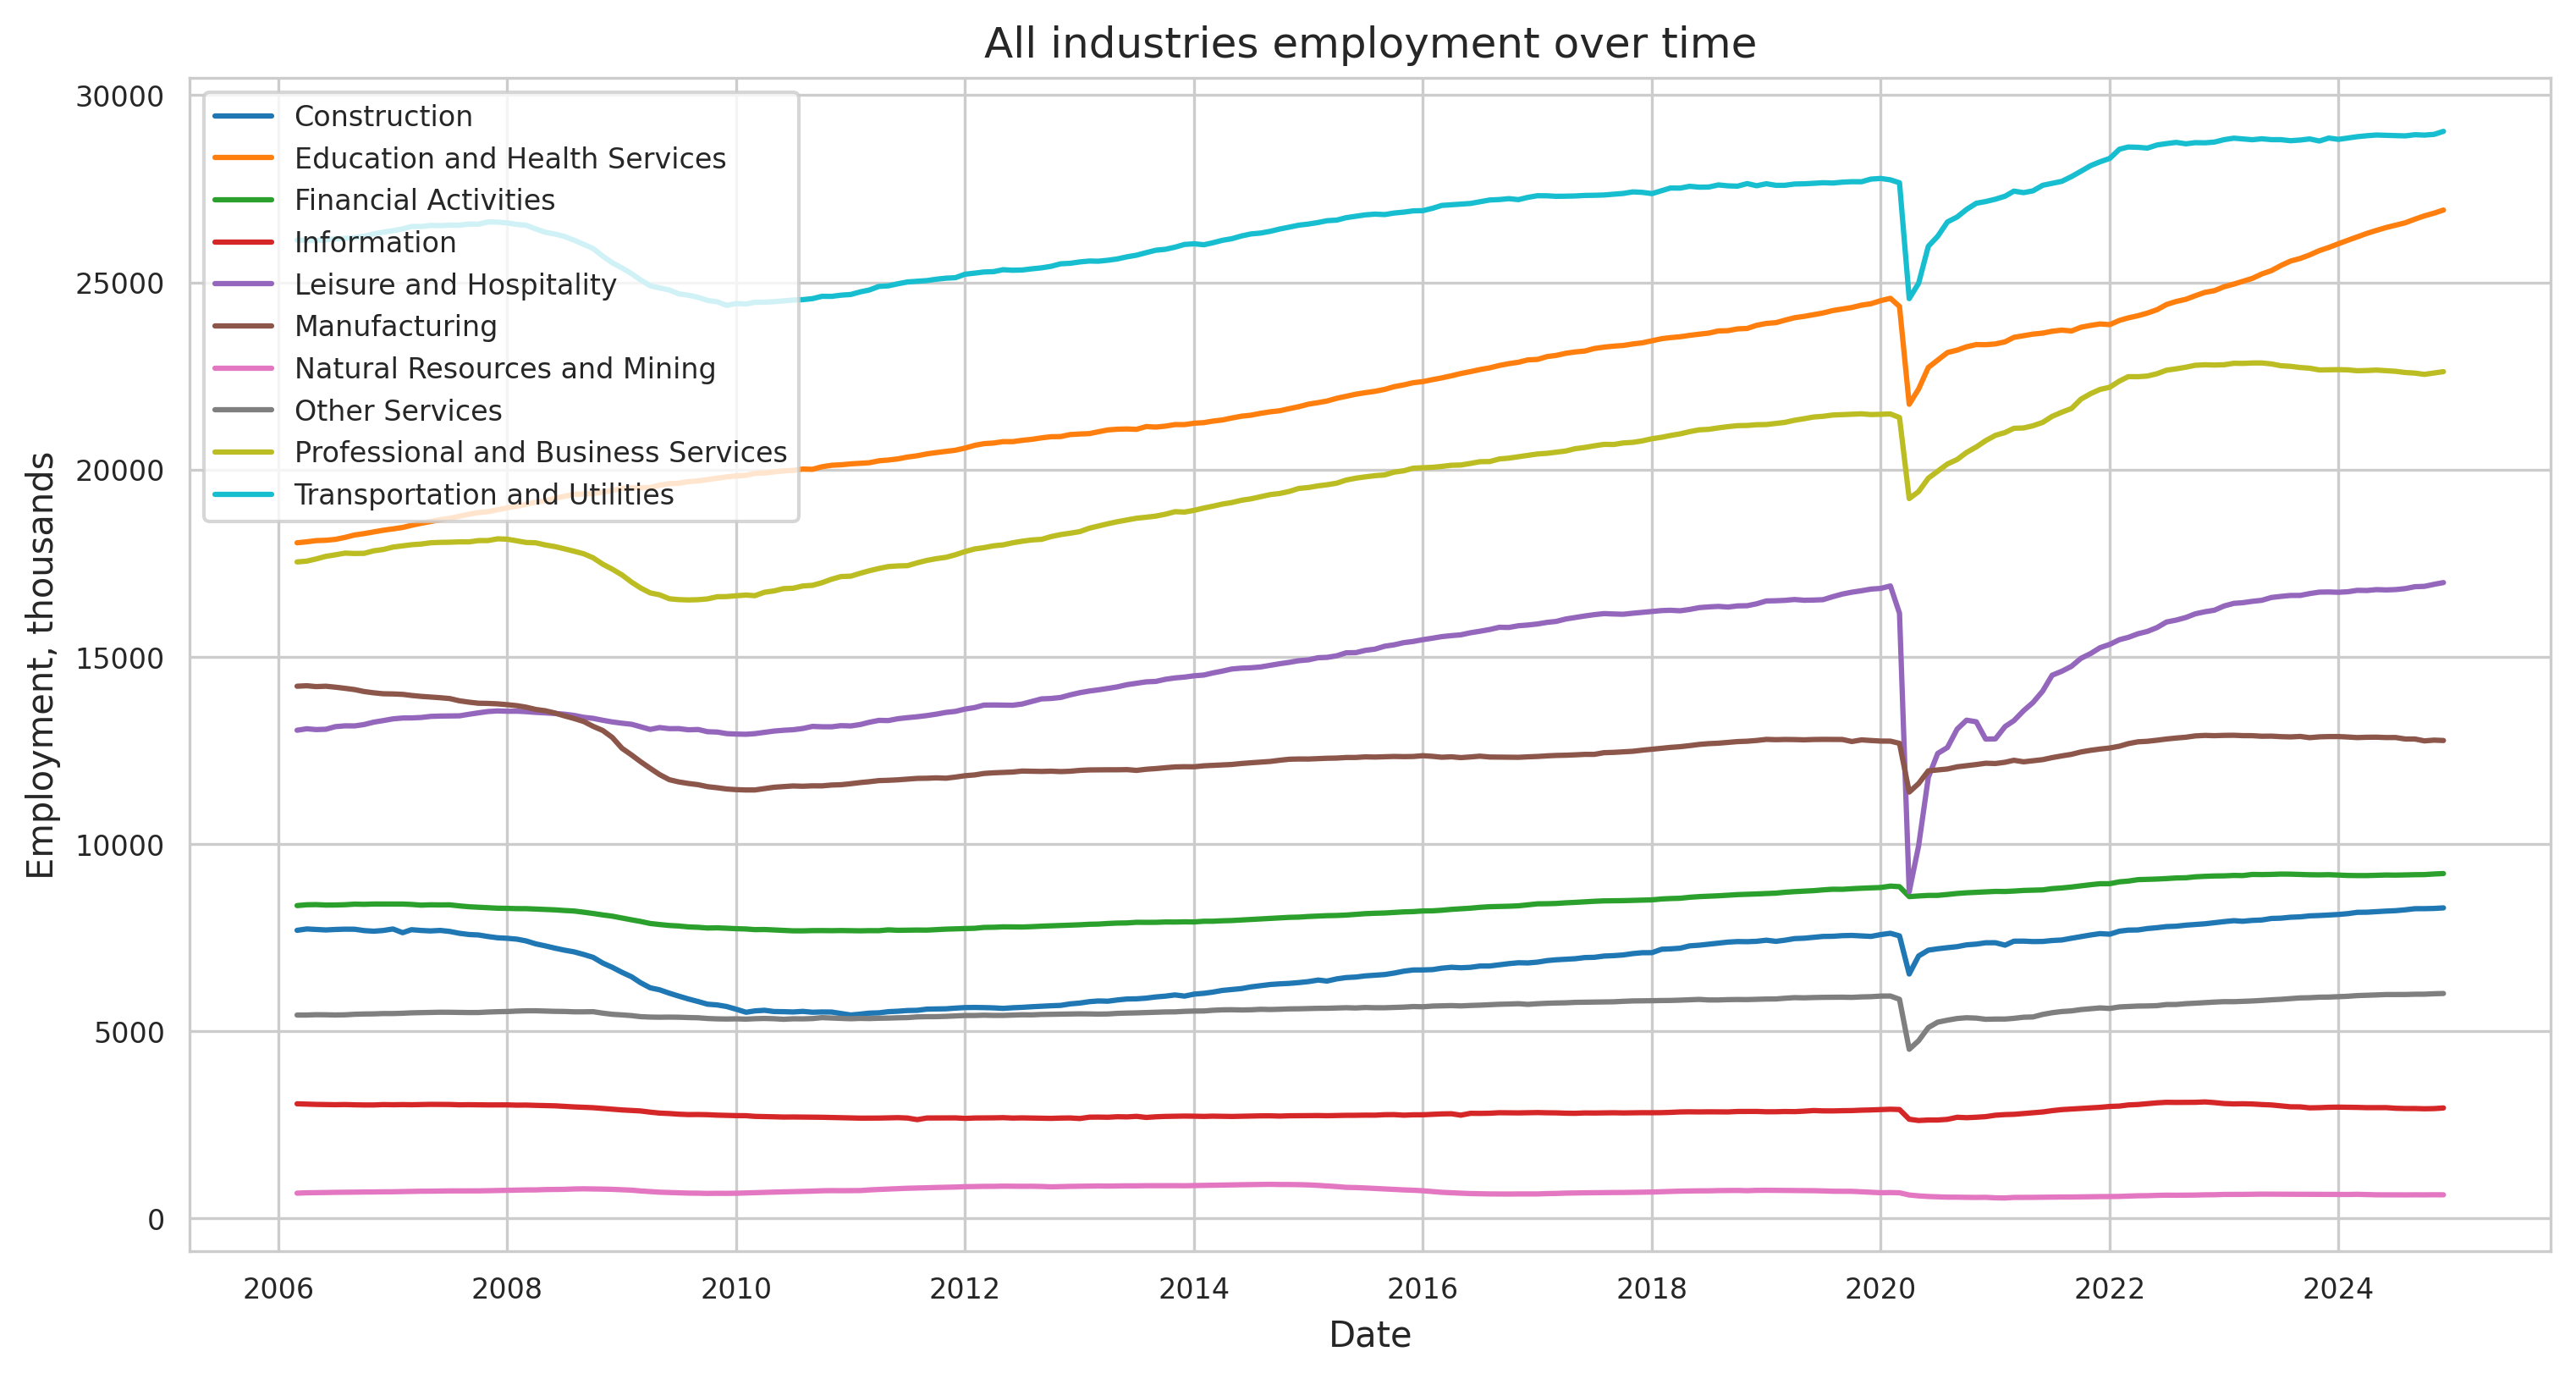

In [8]:
industries = df.industry.unique()
plt.figure(figsize=(12, 6))
for ind in industries:
    sub = df[df.industry == ind]
    plt.plot(sub.date, sub.y, label=ind)
plt.legend()
plt.title("All industries employment over time")
plt.xlabel("Date")
plt.ylabel("Employment, thousands")
plt.savefig(VIS_DIR/"all_industries_employment.png", bbox_inches='tight')
plt.show()
plt.close()

## 3. Unemployment Rate by Industry

/tmp/ipykernel_20387/2633327567.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


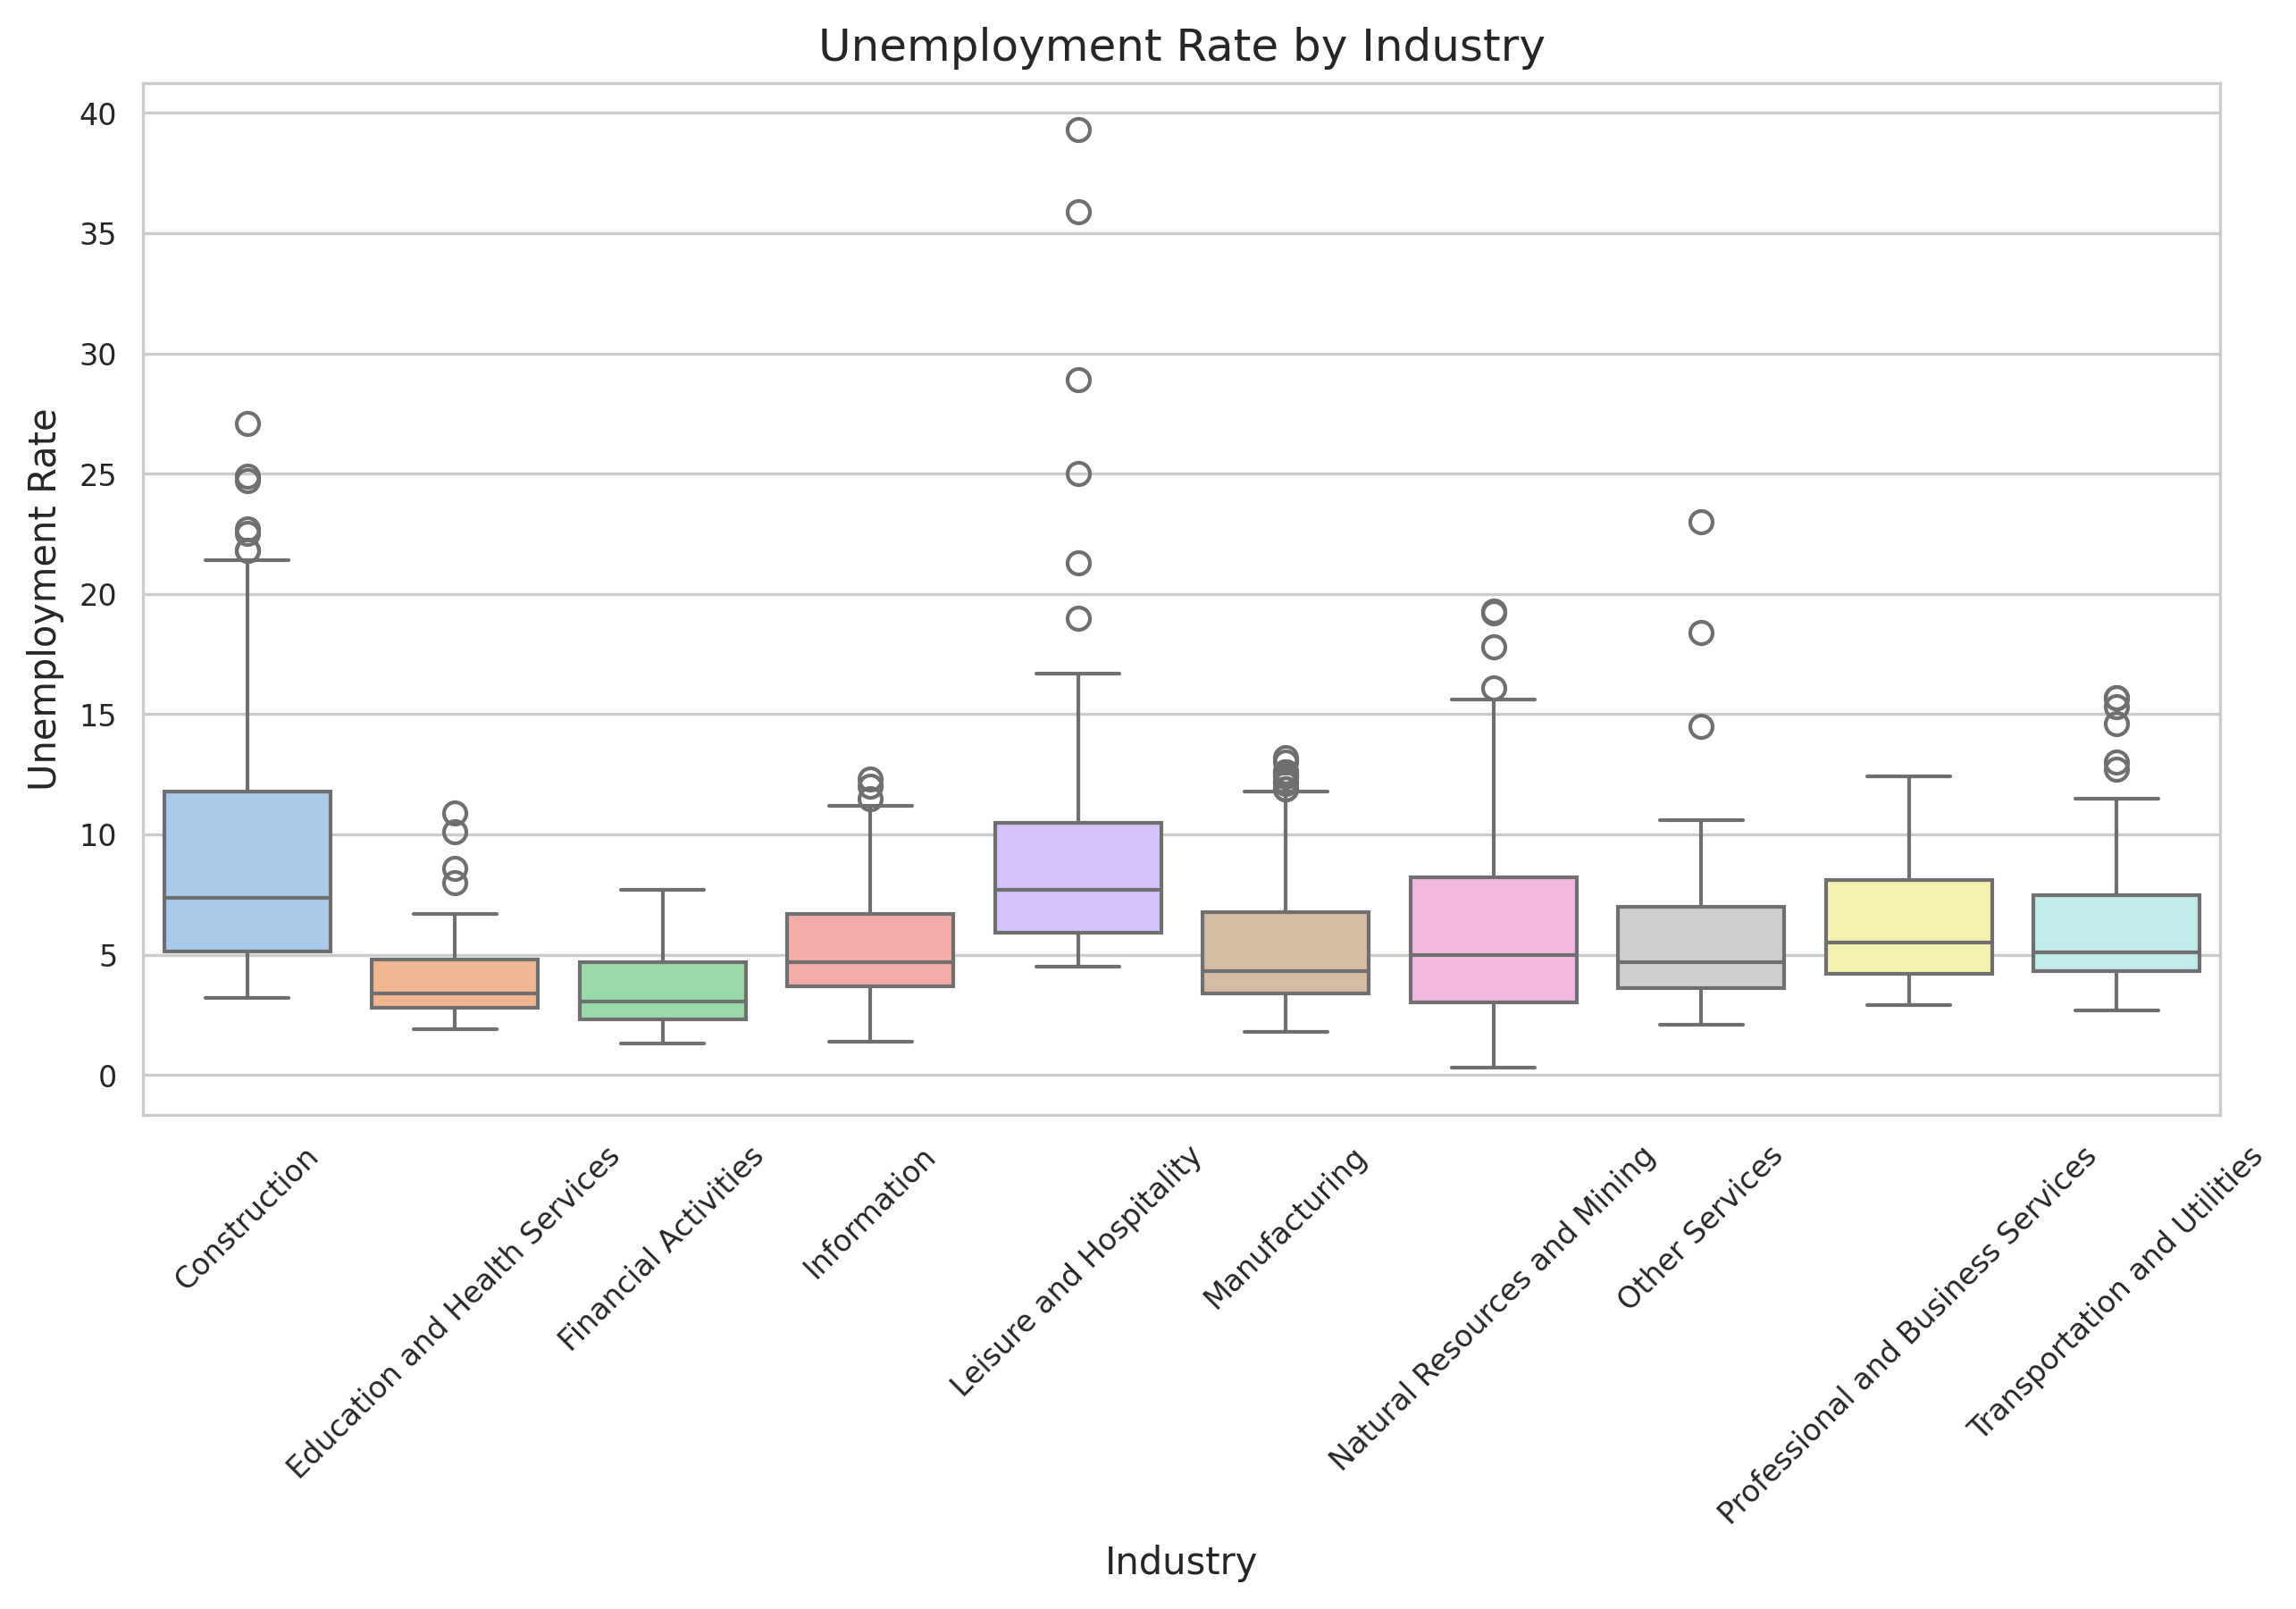

In [11]:
fig, ax = plt.subplots()
sns.boxplot(
    x="industry", y="unemployment_rate", data=df,
    palette="pastel", ax=ax
)

plt.setp(ax.get_xticklabels(), rotation=VISUALIZATION_CONFIG['x_rotation'])
ax.set_title("Unemployment Rate by Industry")
ax.set_xlabel("Industry")
ax.set_ylabel("Unemployment Rate")
fig.savefig(VIS_DIR/"unemp_rate_boxplot.png", bbox_inches='tight')
plt.show()
plt.close()

## 4. Yearly Average Employment Correlations

/tmp/ipykernel_20387/1662557516.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  corr = wide.resample("A").mean().corr()


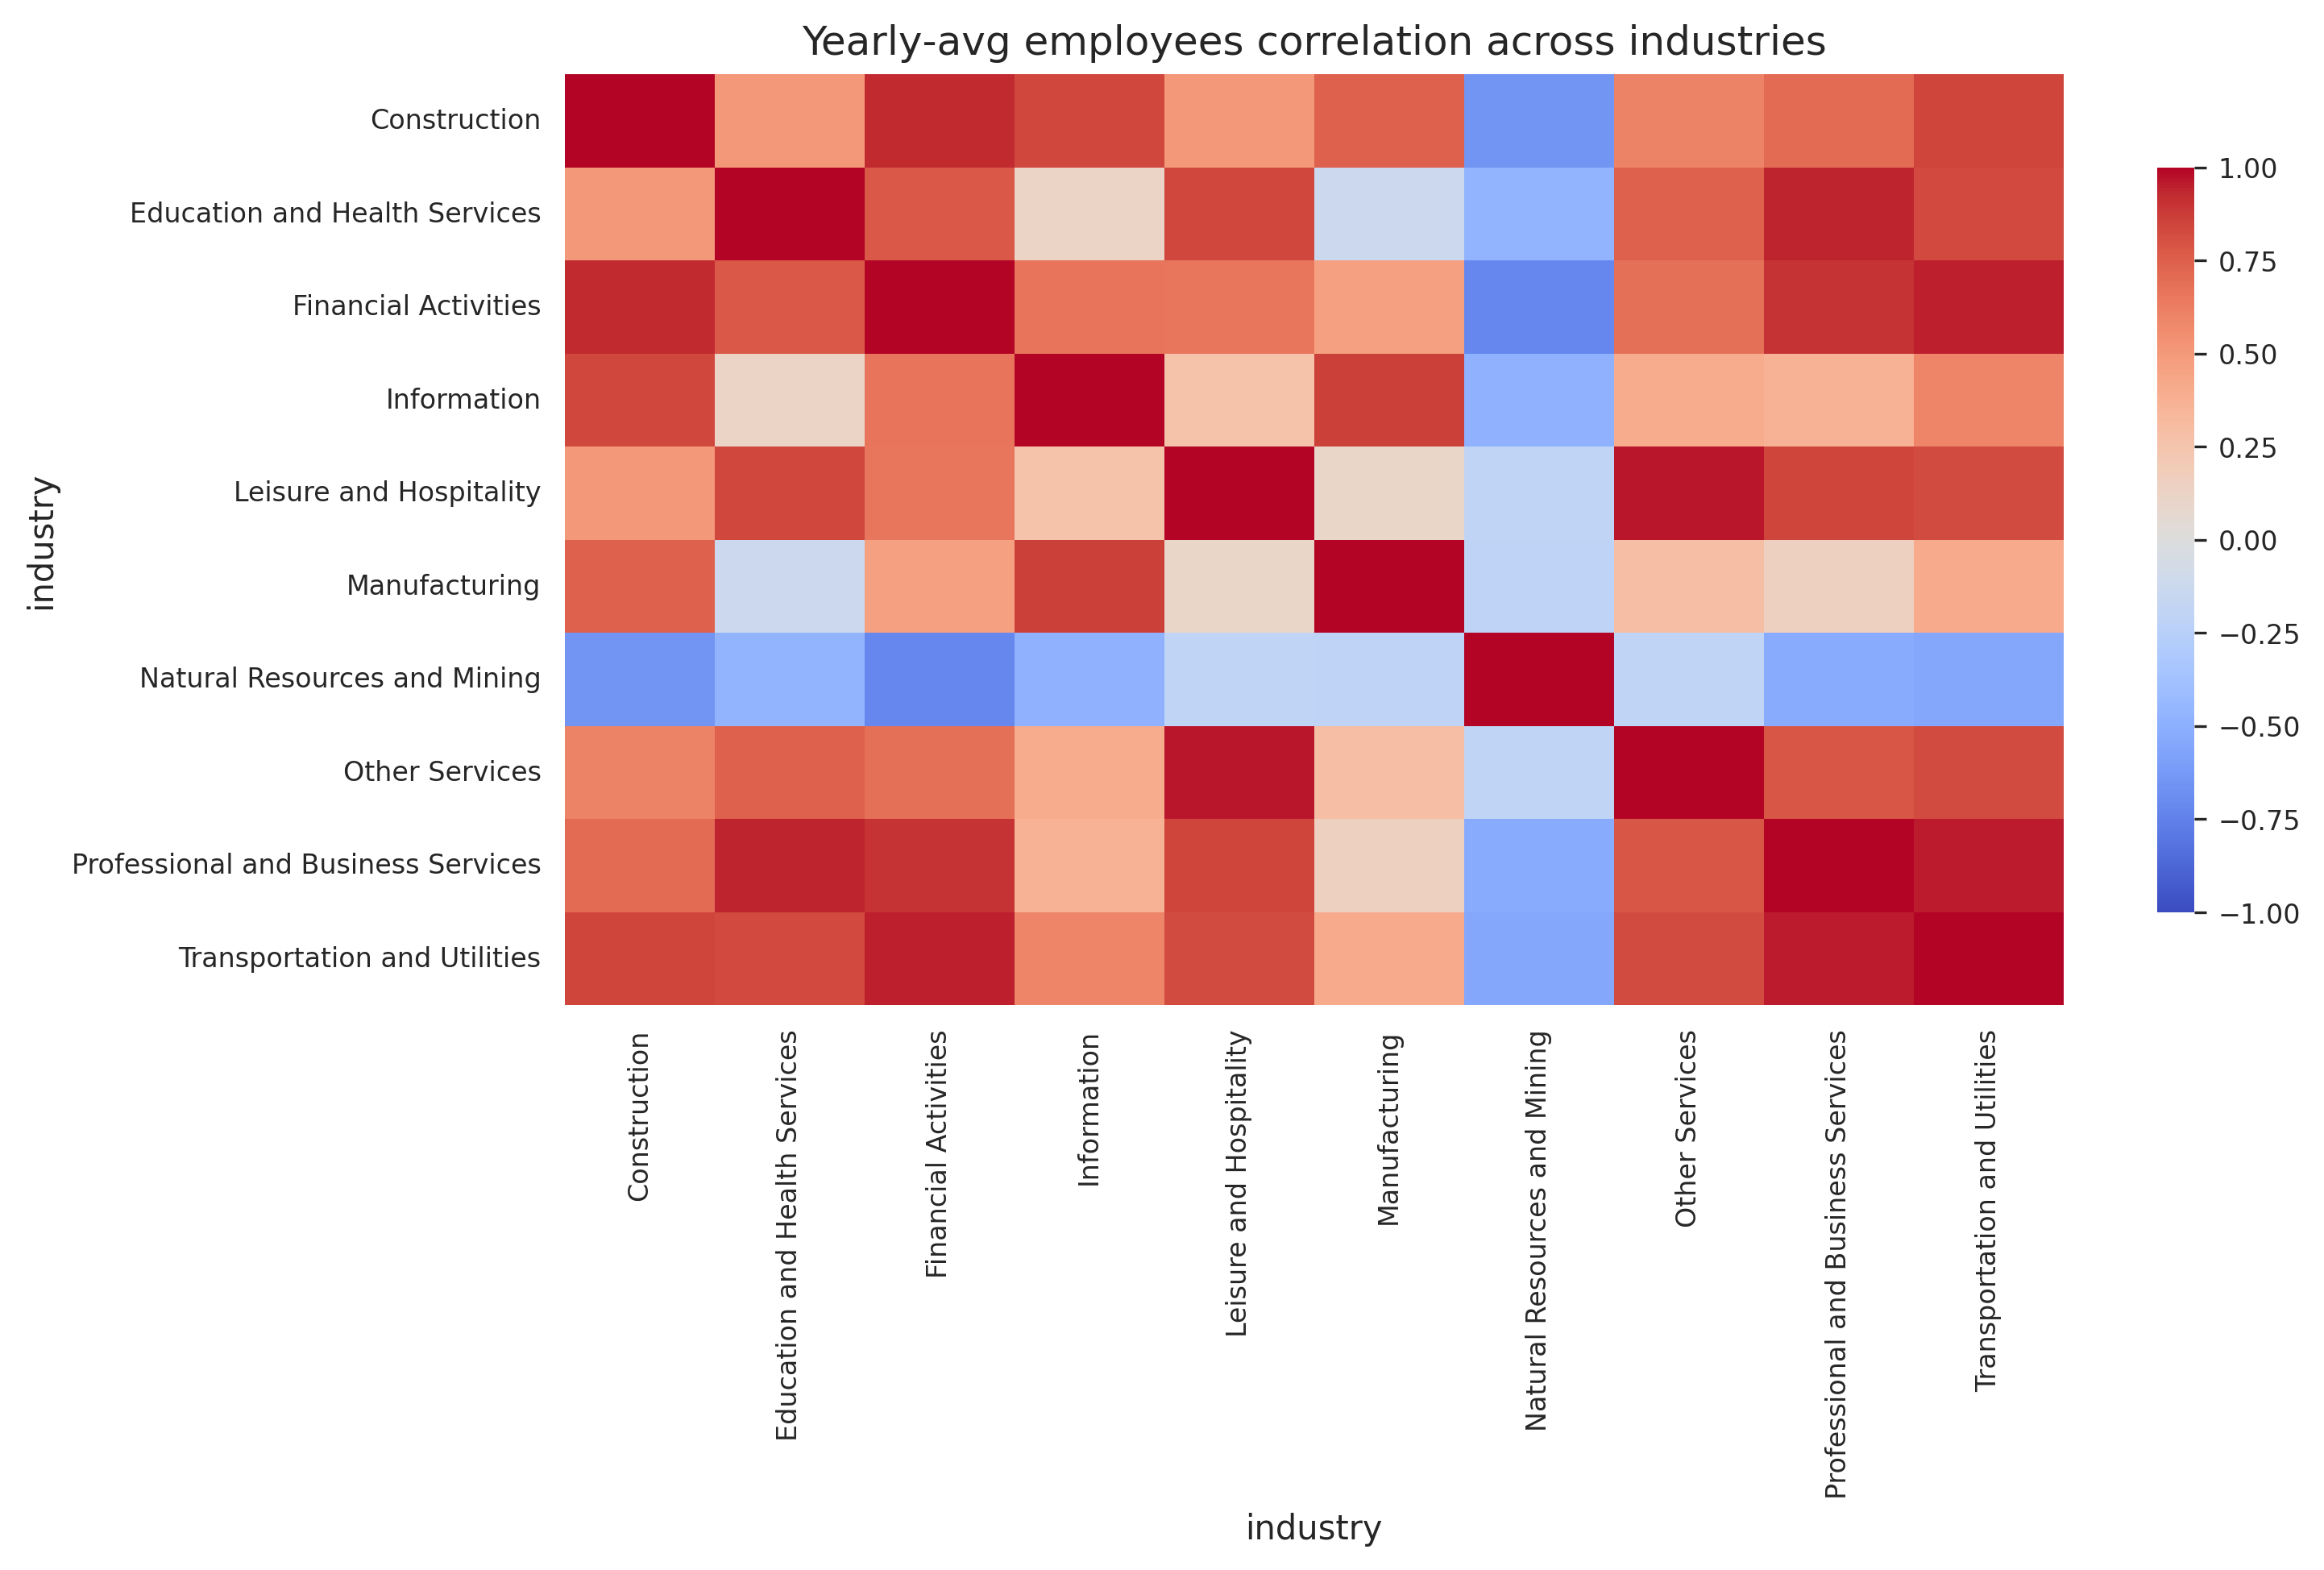

In [12]:
wide = df.pivot(index="date", columns="industry", values="y")
corr = wide.resample("A").mean().corr()

fig, ax = plt.subplots()
sns.heatmap(
    corr, cmap="coolwarm", vmin=-1, vmax=1,
    cbar_kws={'shrink': .8}, ax=ax
)
ax.set_title("Yearly‐avg employees correlation across industries")
fig.savefig(VIS_DIR/"employees_corr_heatmap.png", bbox_inches='tight')
plt.show()
plt.close()

## 5. Stationarity and Seasonality

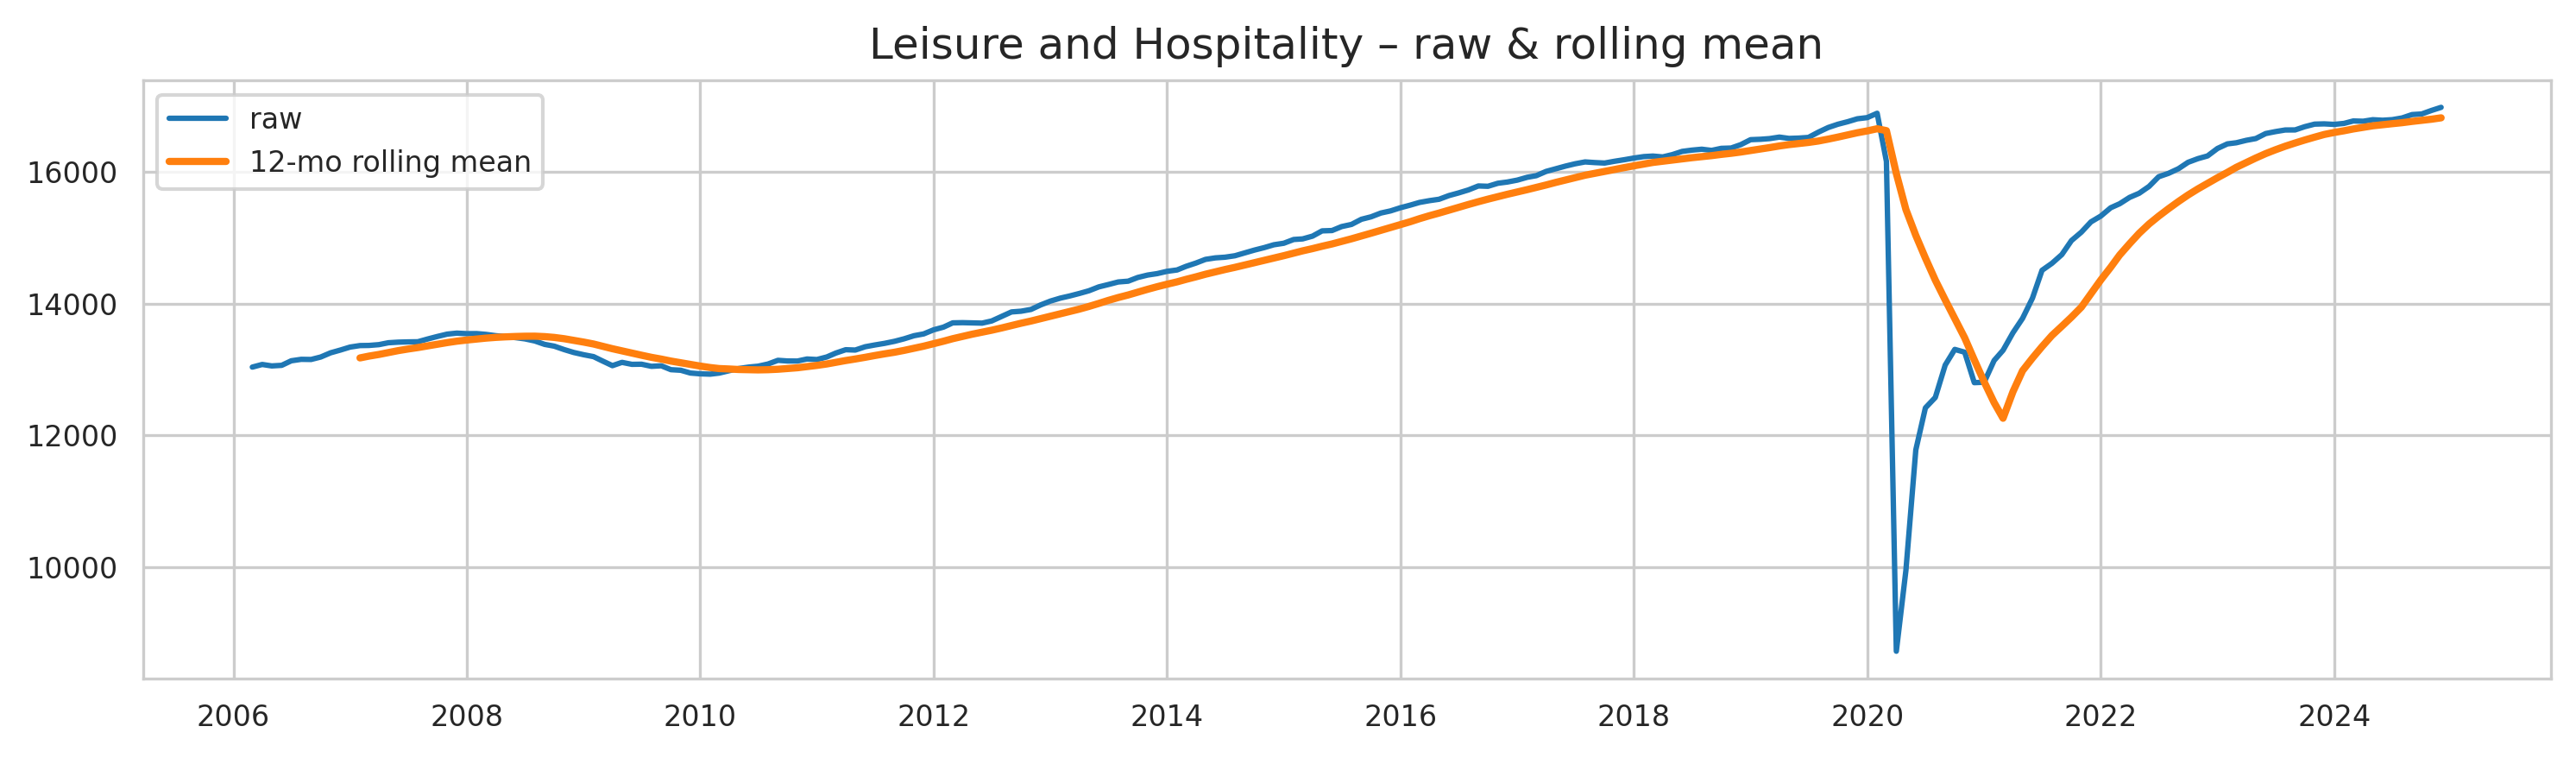

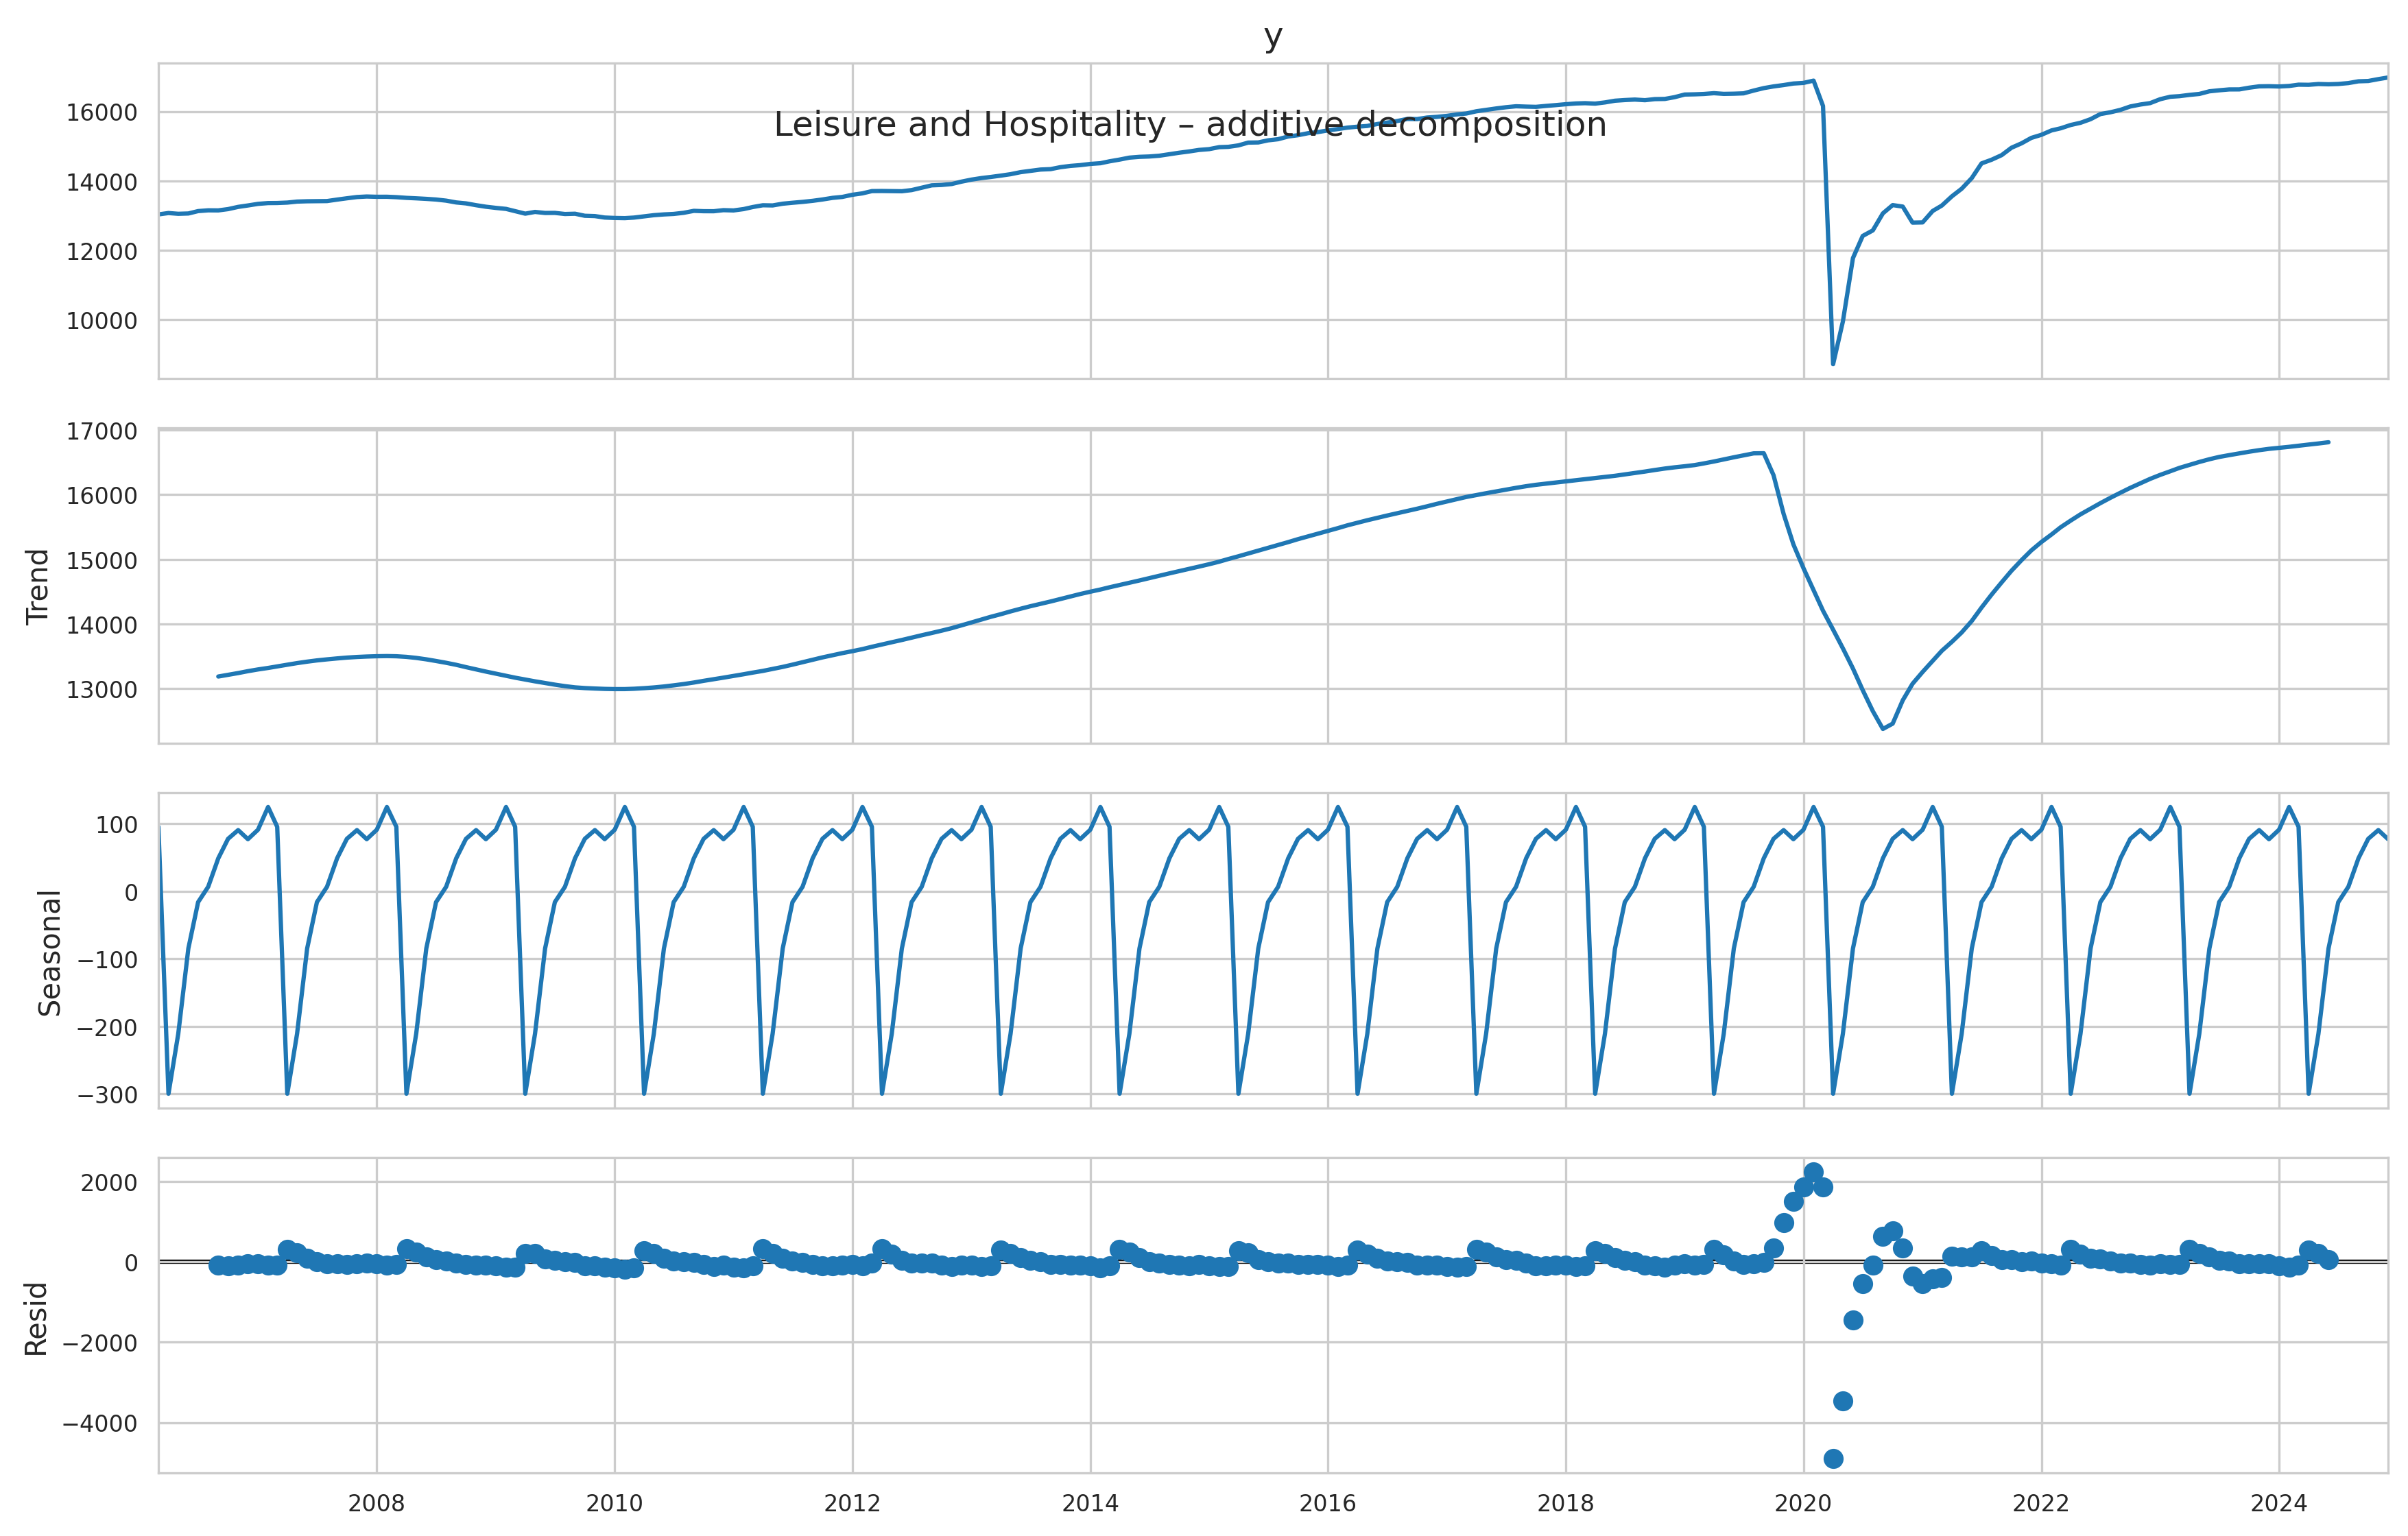

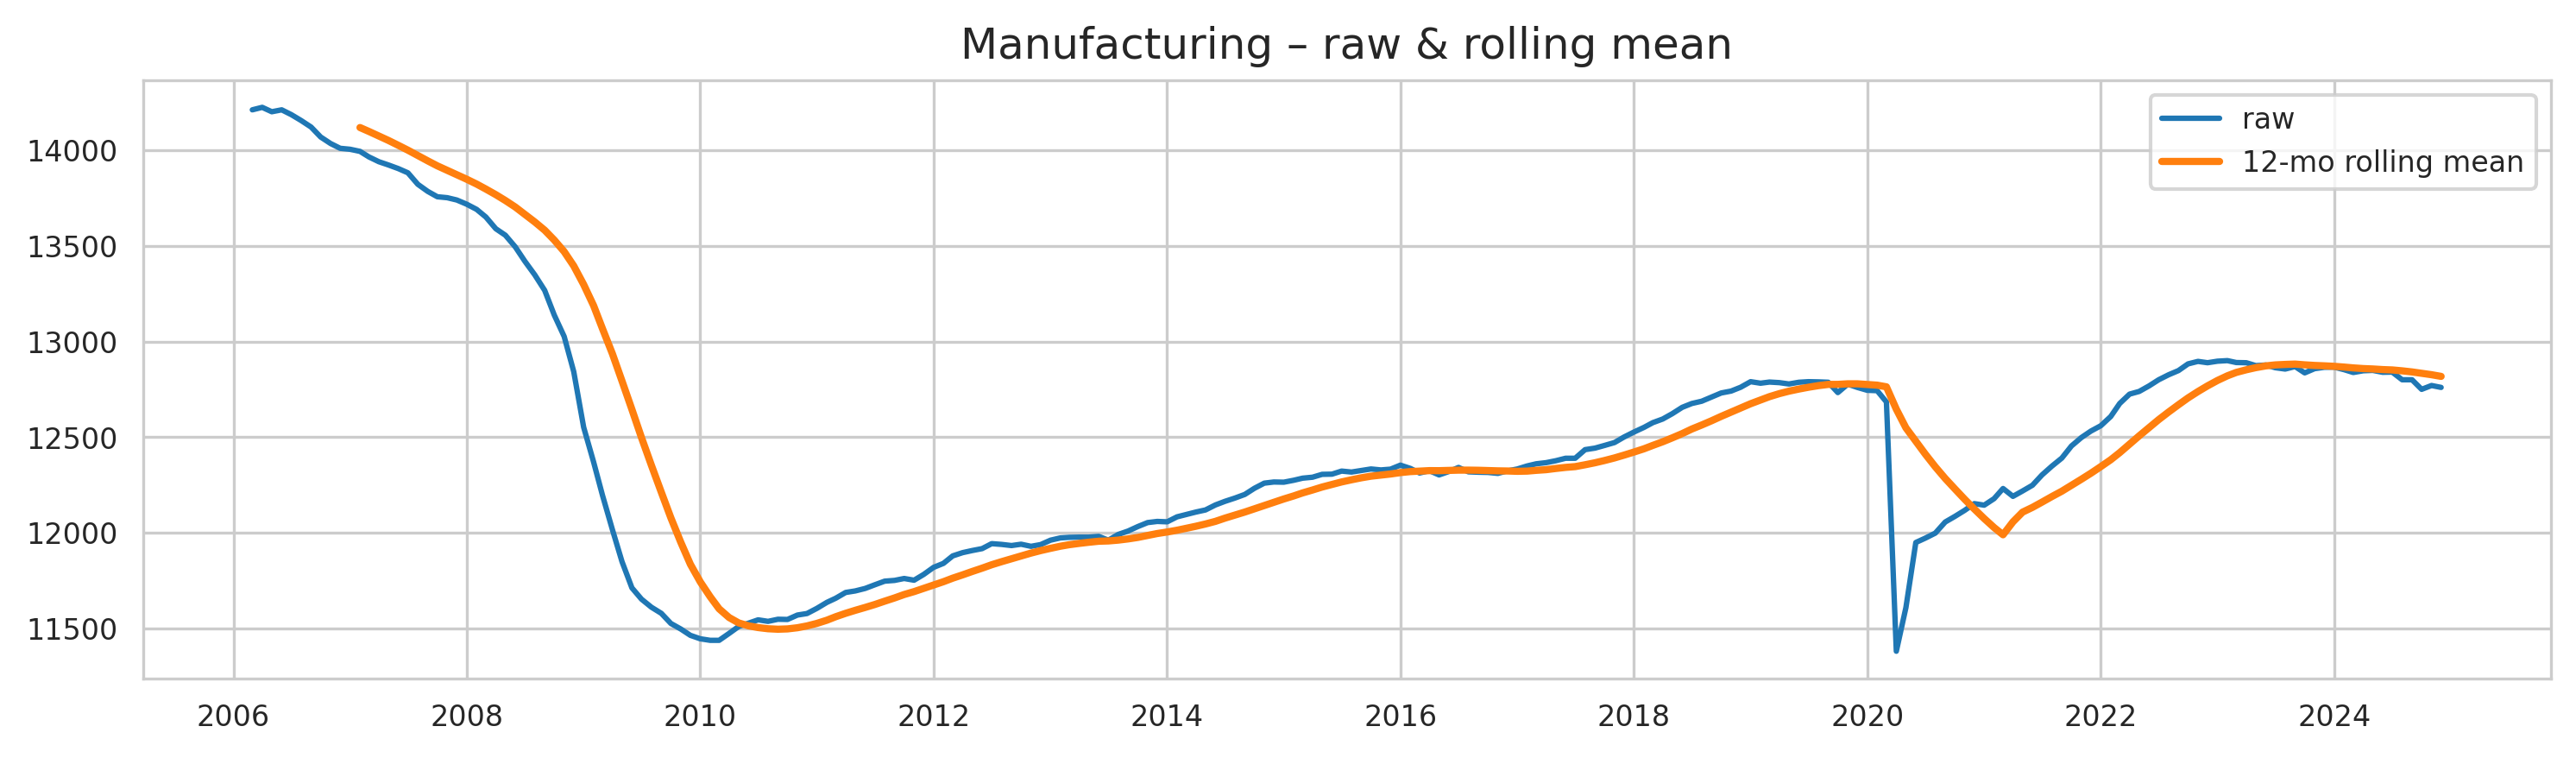

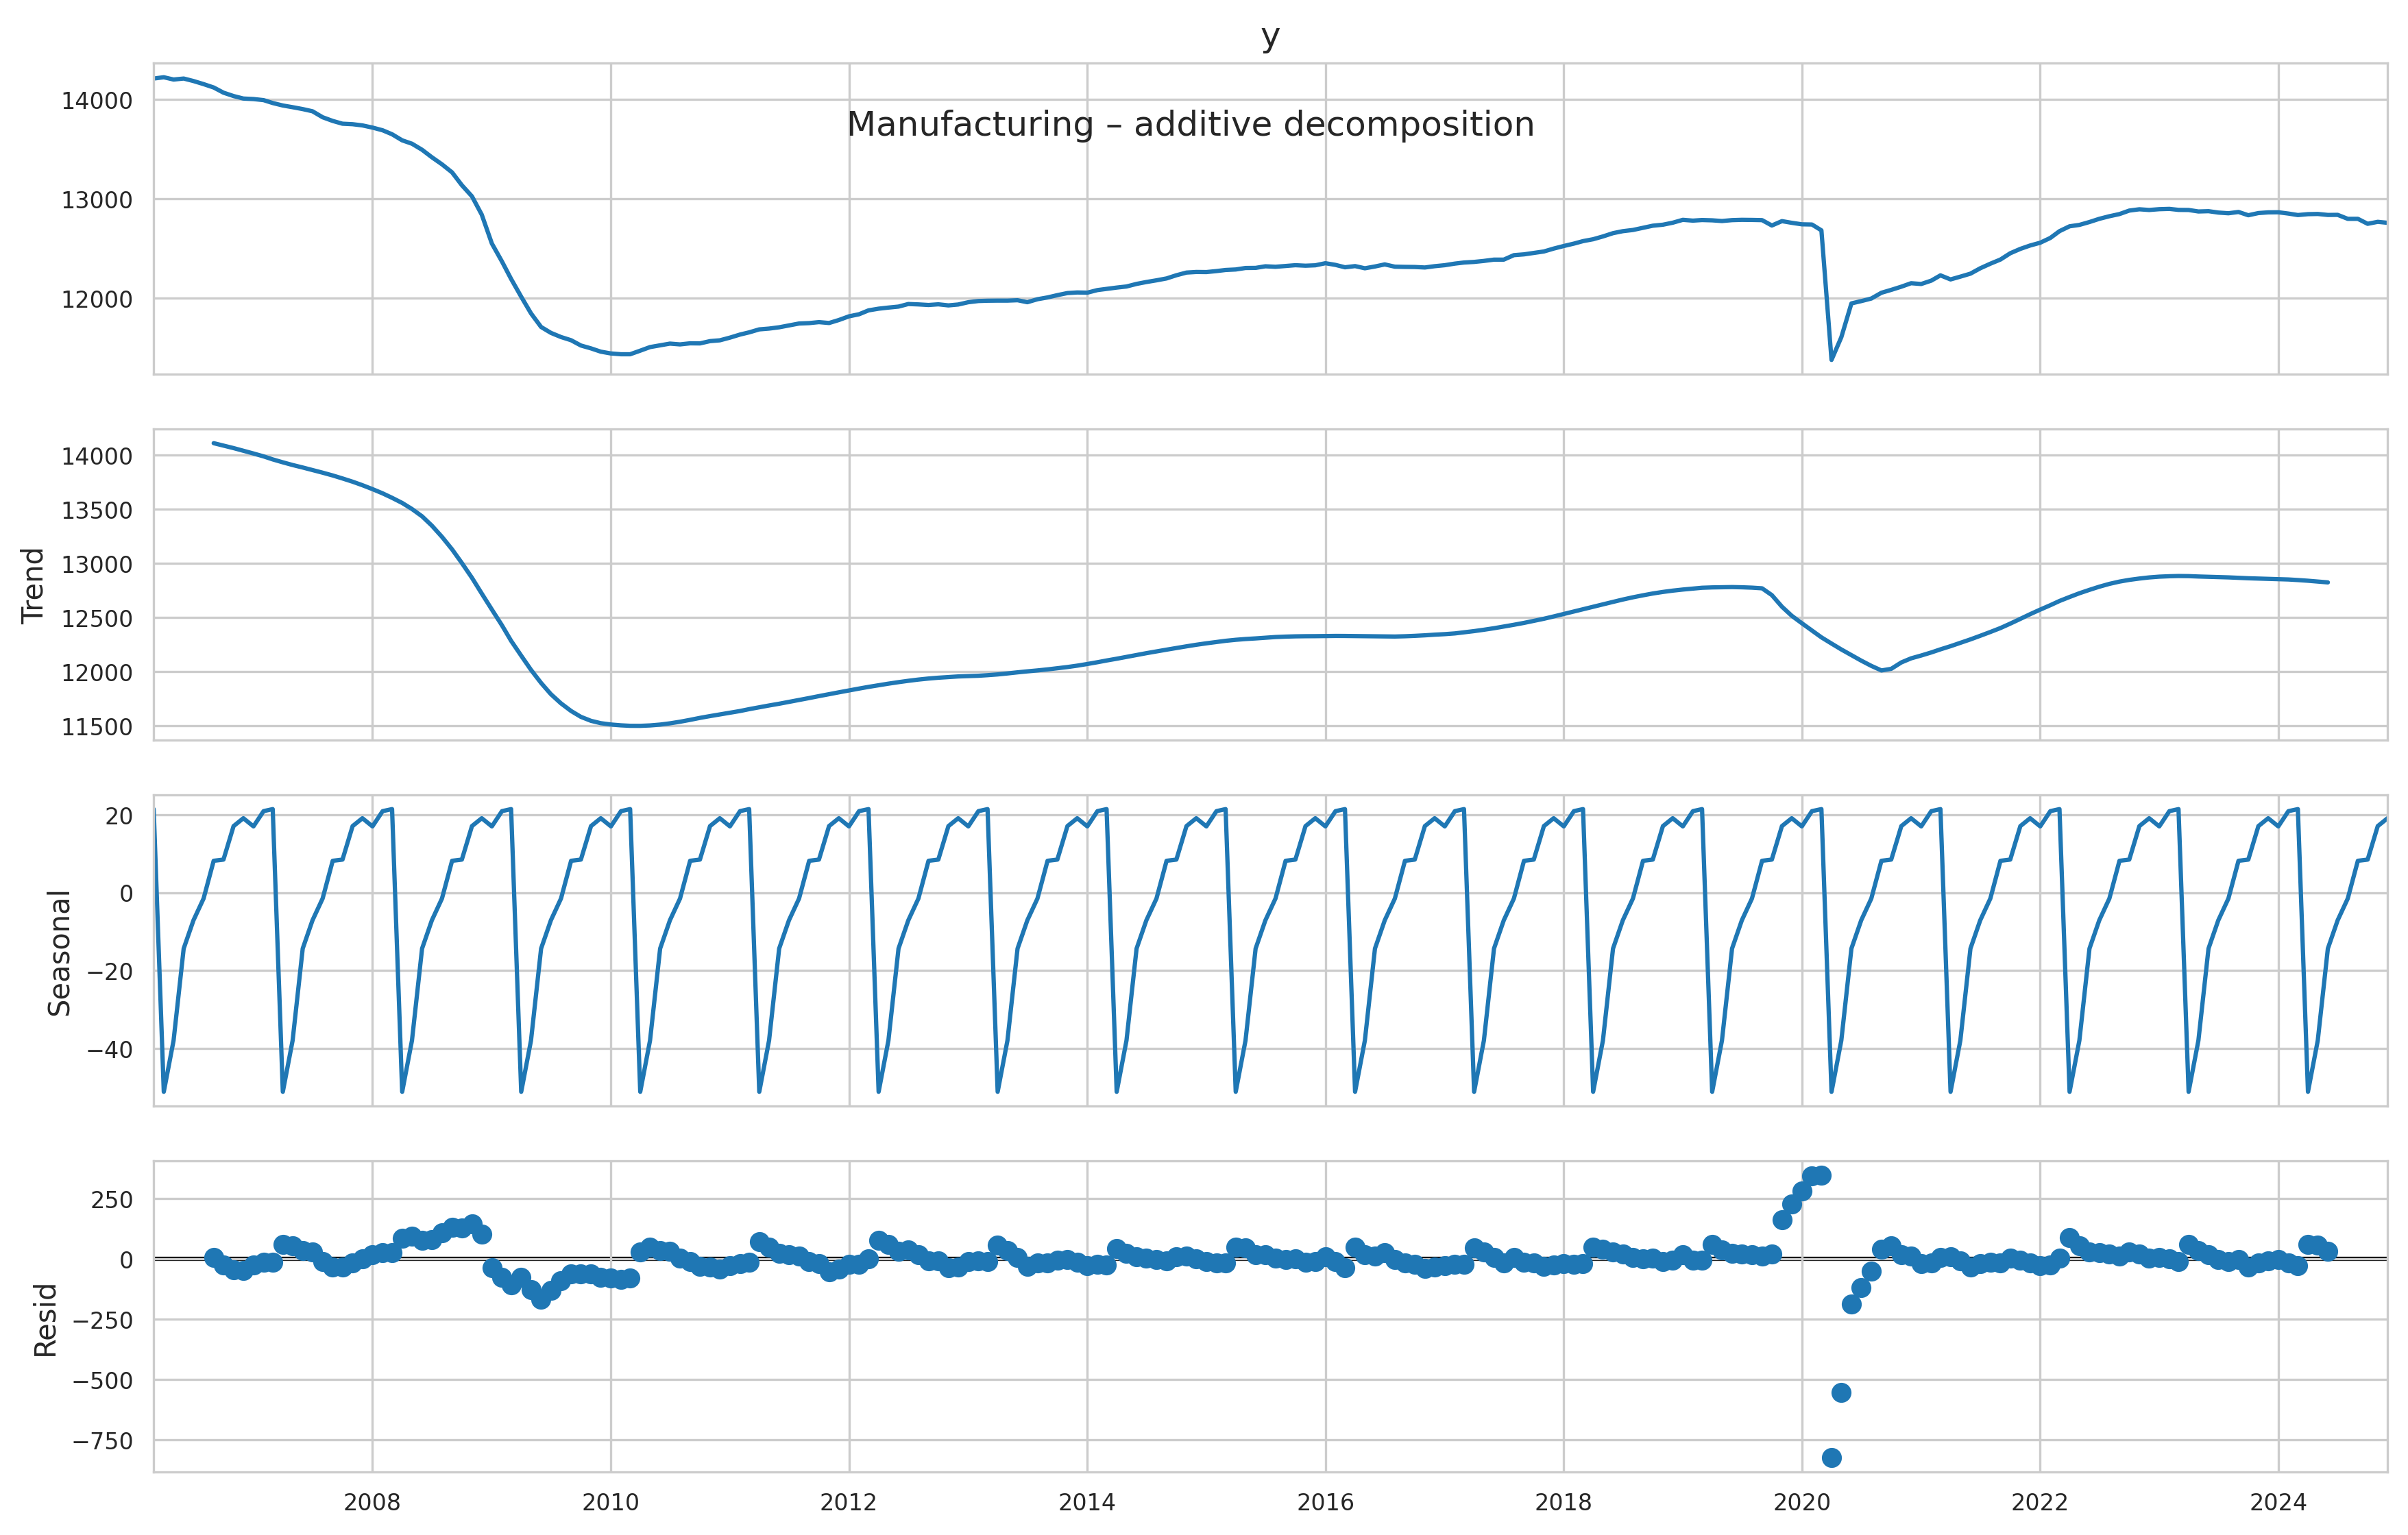

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# pick one or two industries
for ind in ['Leisure and Hospitality','Manufacturing']:
    series = df.loc[df.industry==ind, ['date','y']].set_index('date').y

    # a) Rolling‐mean vs raw
    plt.figure(figsize=(12,3))
    plt.plot(series, label='raw')
    plt.plot(series.rolling(window=12).mean(), label='12-mo rolling mean', lw=2)
    plt.title(f'{ind} – raw & rolling mean')
    plt.legend()
    plt.show()

    # b) Seasonal decomposition
    res = seasonal_decompose(series, model='additive', period=12)
    fig = res.plot()
    fig.set_size_inches(12,8)
    plt.suptitle(f'{ind} – additive decomposition', y=0.9)
    plt.show()

## 6. Autocorrelation and Partial Autocorrelation

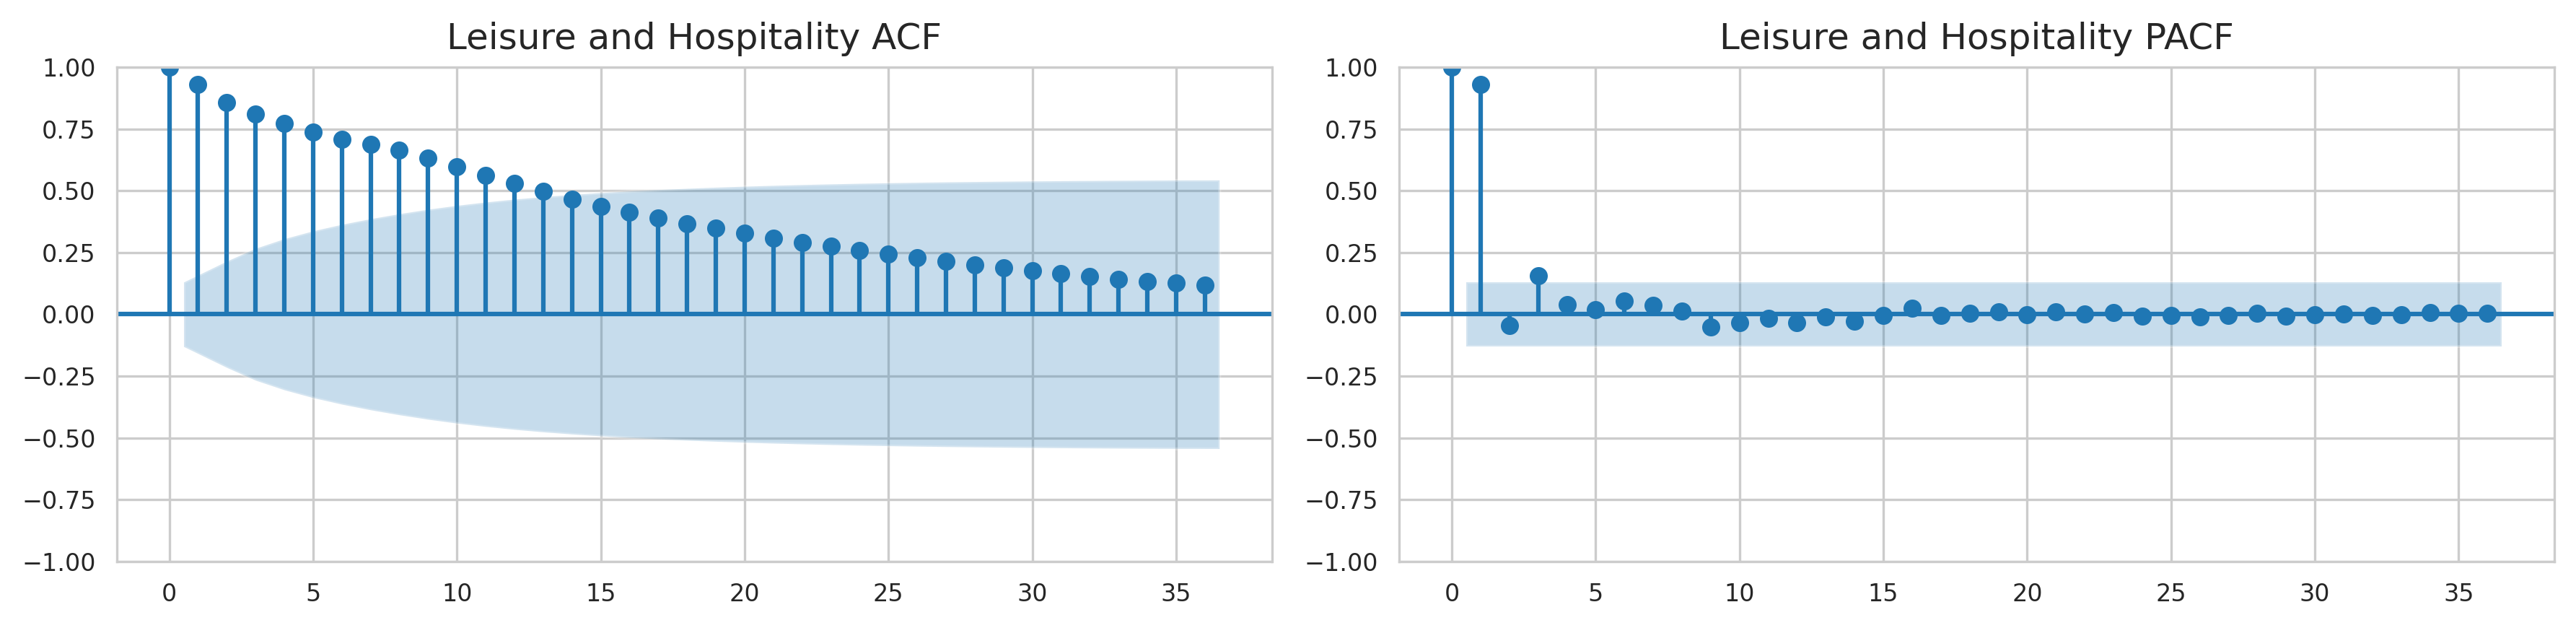

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ind = 'Leisure and Hospitality'
series = df.loc[df.industry==ind].set_index('date').y

fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(series, lags=36, ax=axes[0])
plot_pacf(series, lags=36, ax=axes[1])
axes[0].set_title(f'{ind} ACF')
axes[1].set_title(f'{ind} PACF')
plt.tight_layout()
plt.show()


## 7. Distributions and Outliers

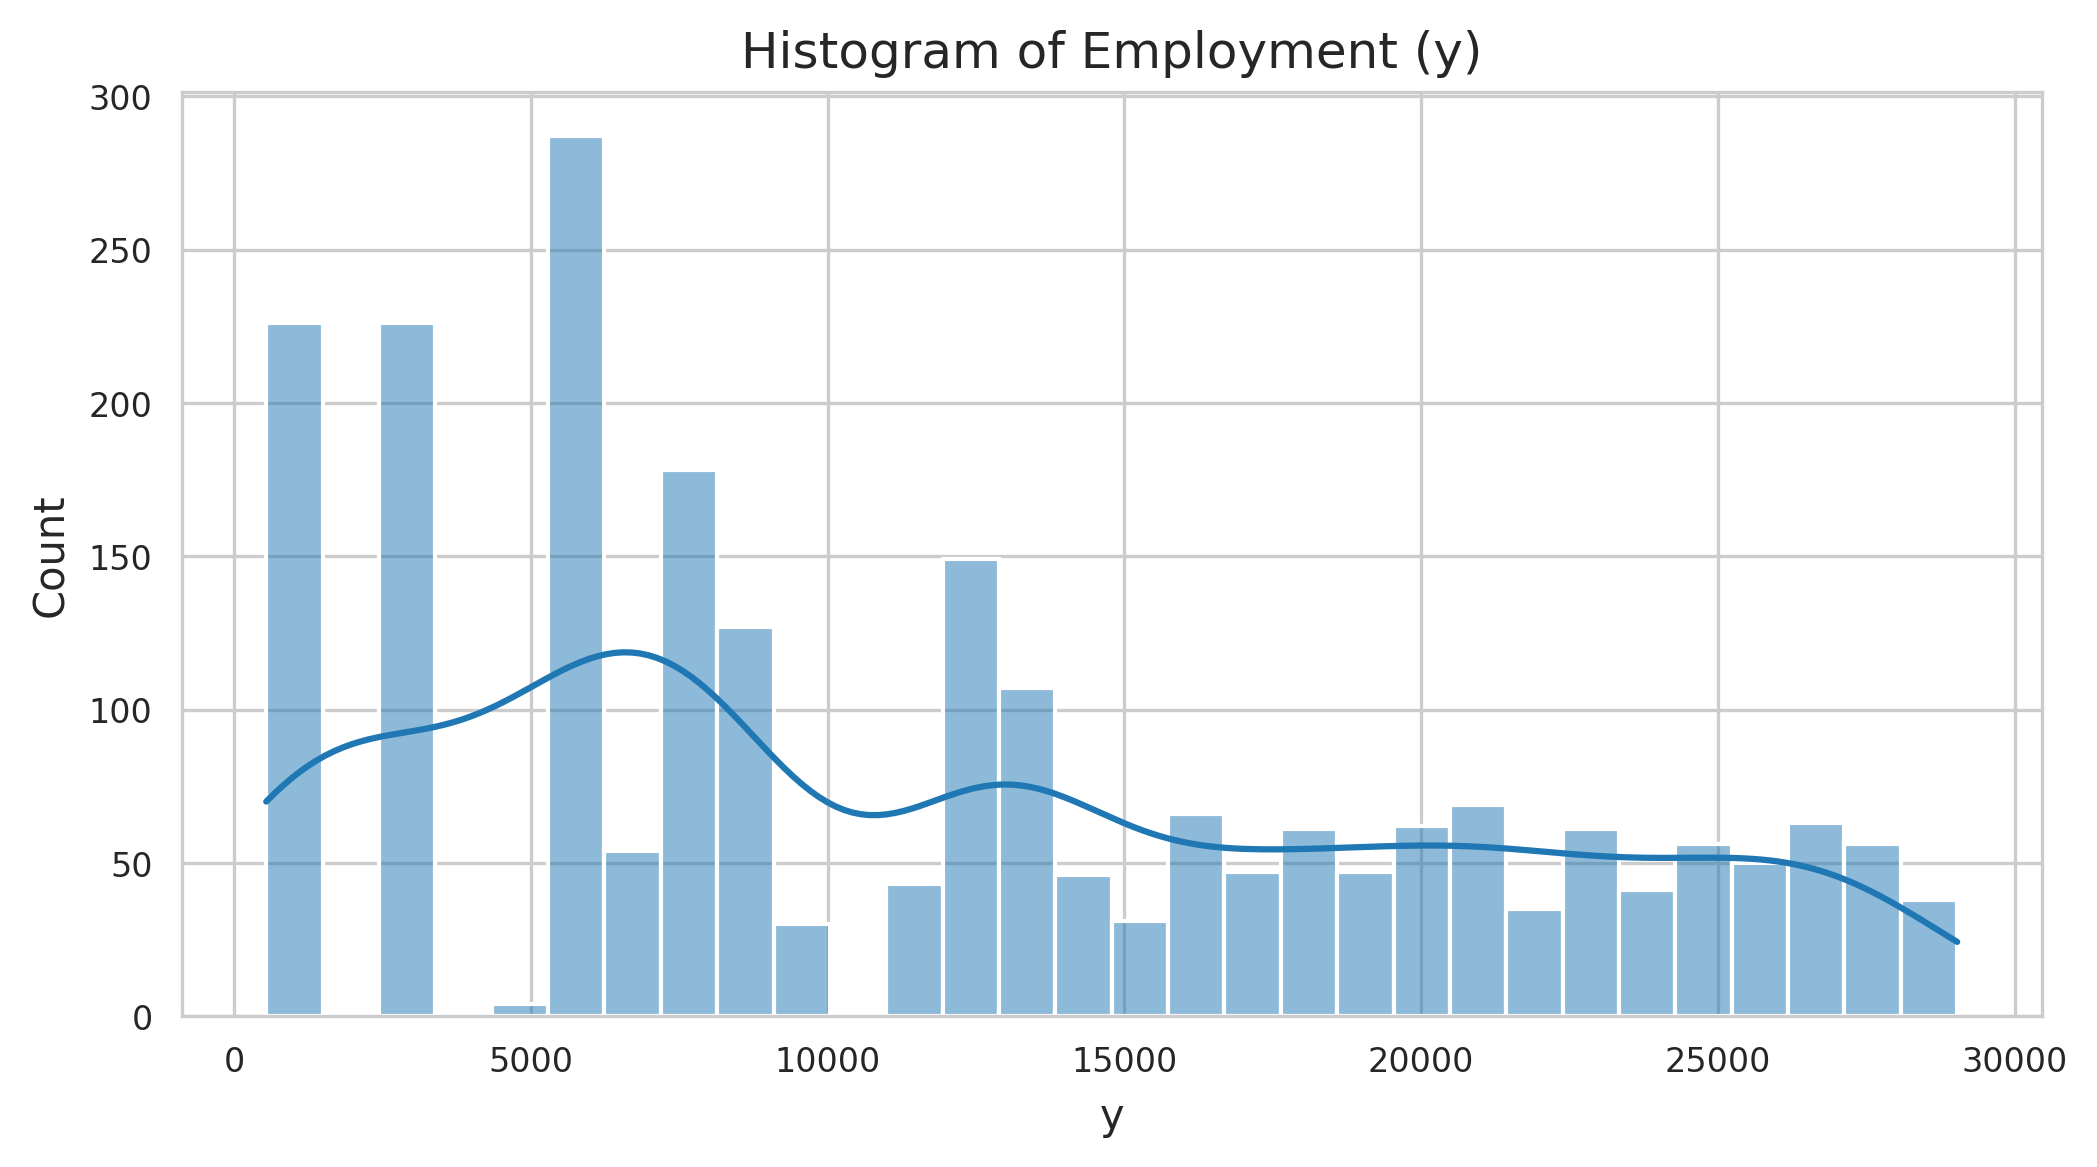

In [15]:
plt.figure(figsize=(8,4))
sns.histplot(df.y, bins=30, kde=True)
plt.title('Histogram of Employment (y)')
plt.show()

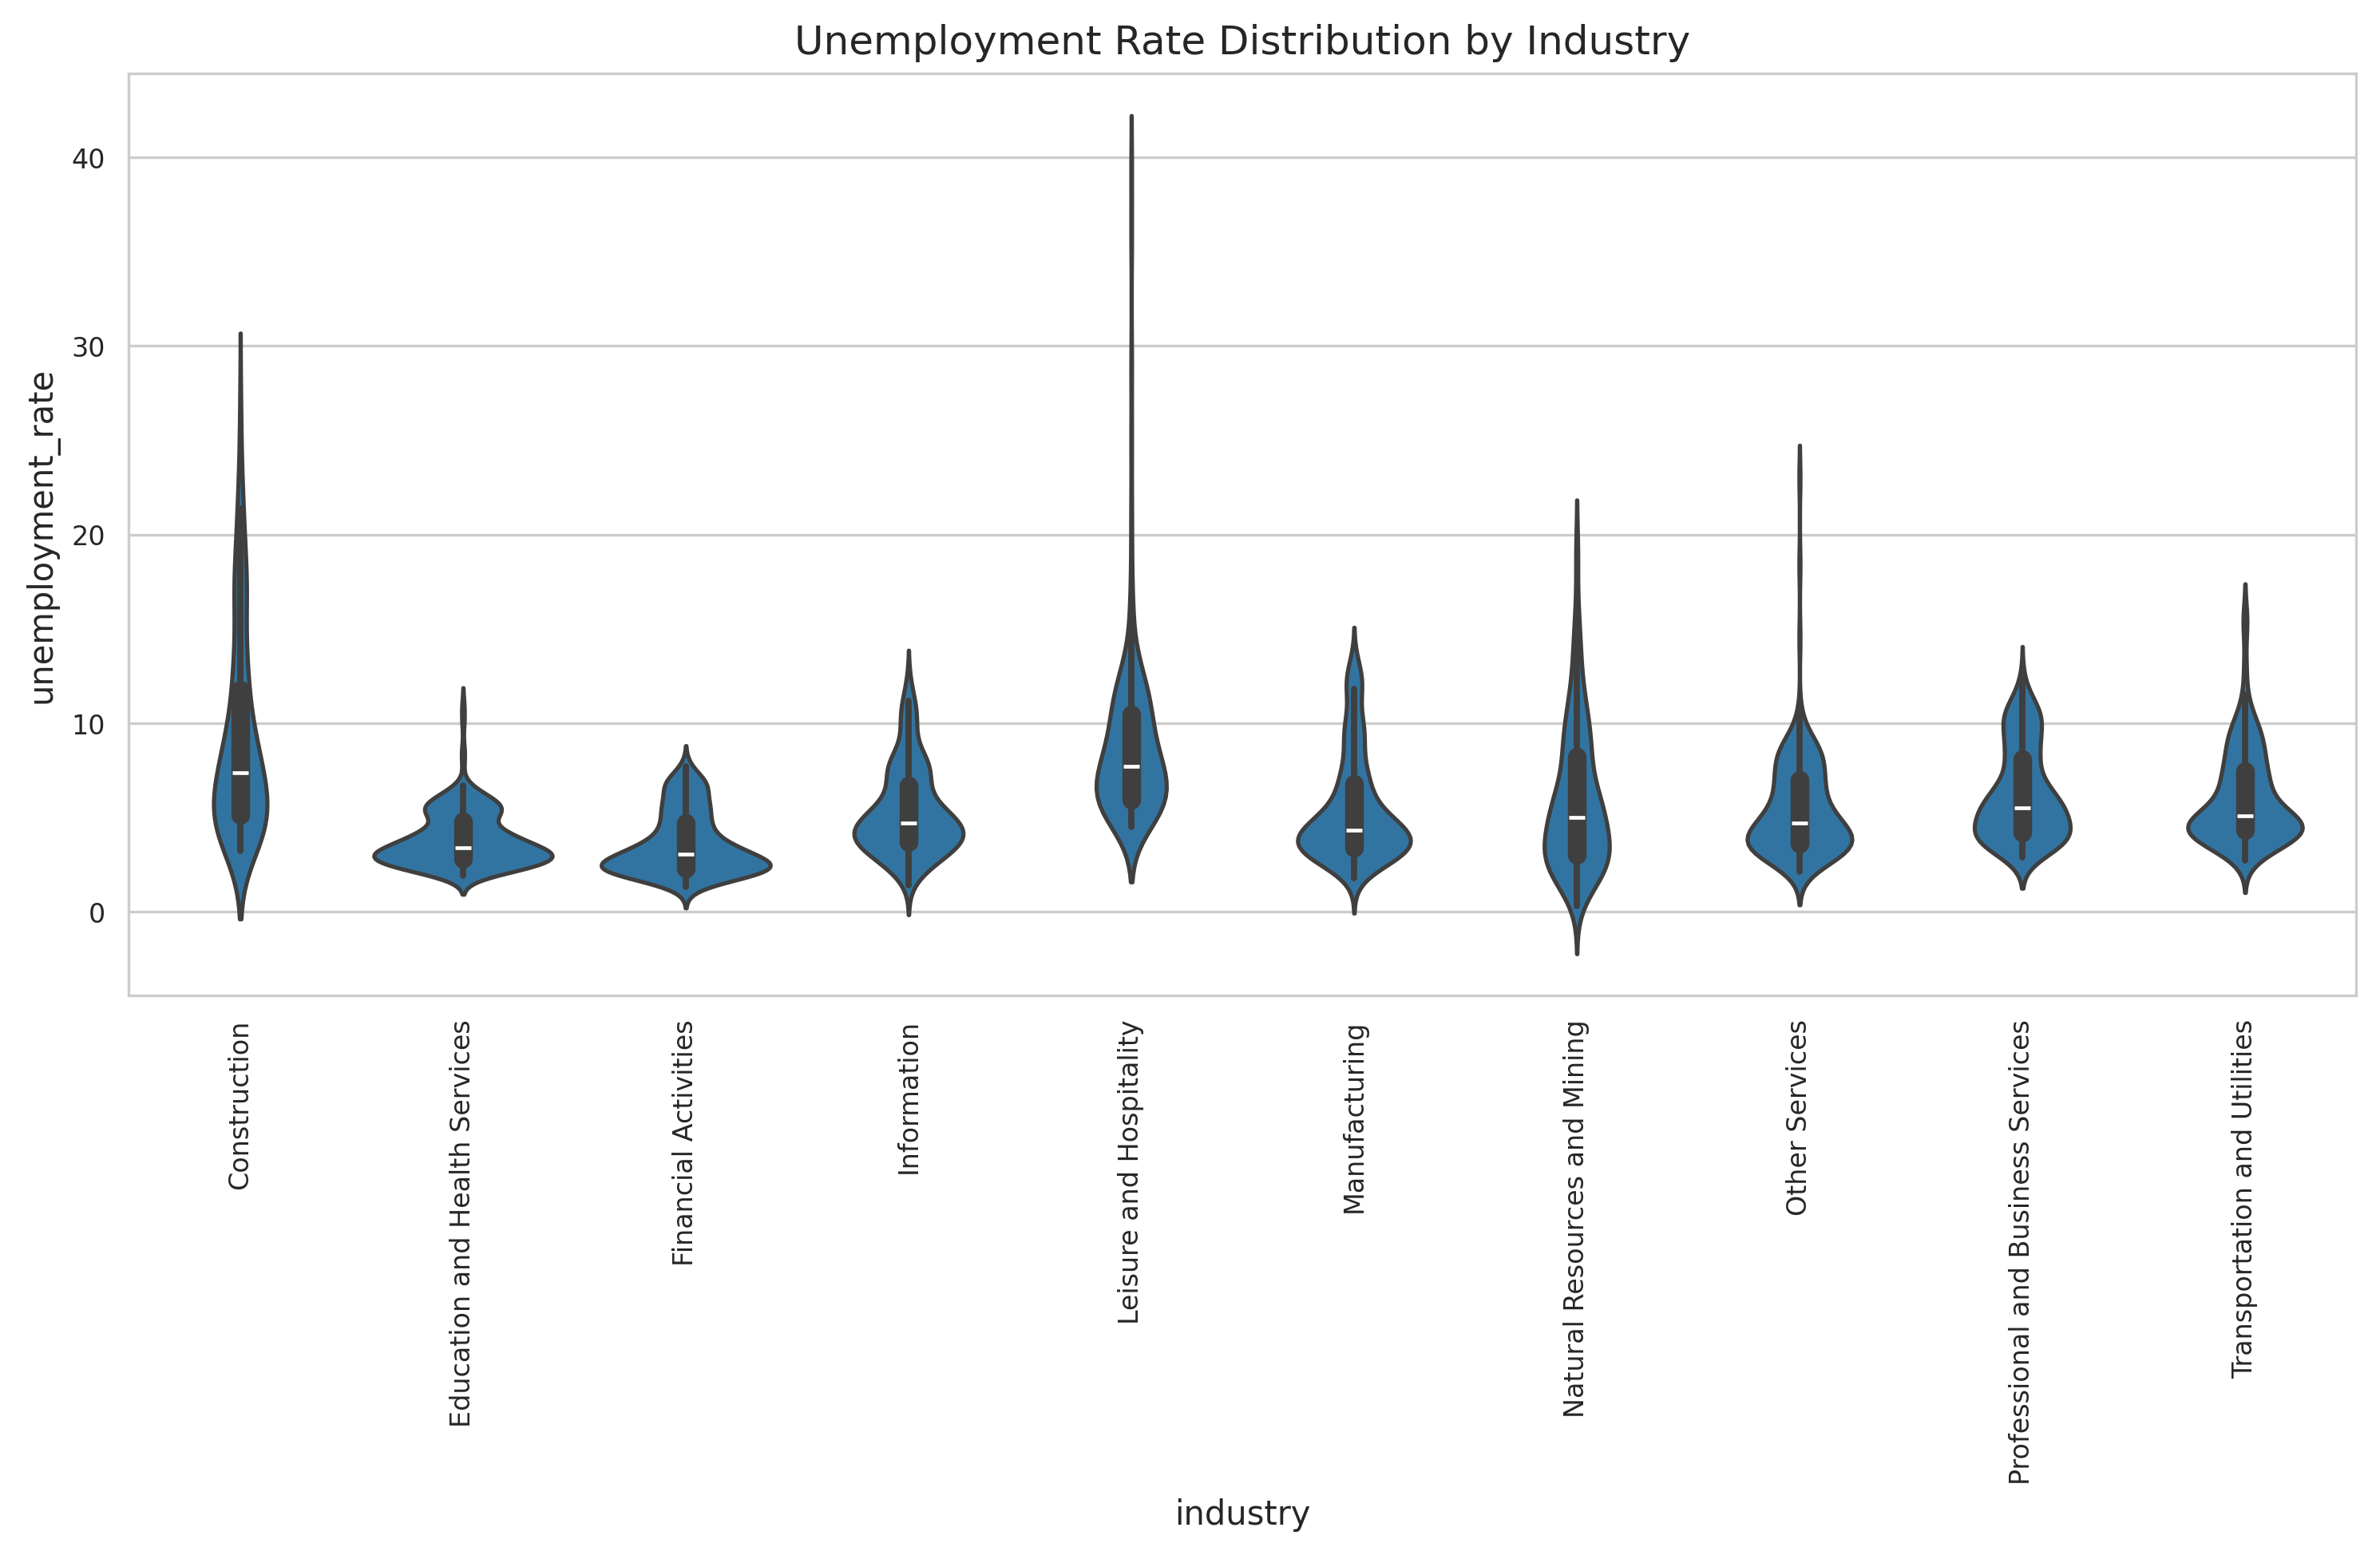

In [16]:
plt.figure(figsize=(12,5))
sns.violinplot(data=df, x='industry', y='unemployment_rate')
plt.xticks(rotation=90)
plt.title('Unemployment Rate Distribution by Industry')
plt.show()

## 8. Full-Sample Correlation Heatmap

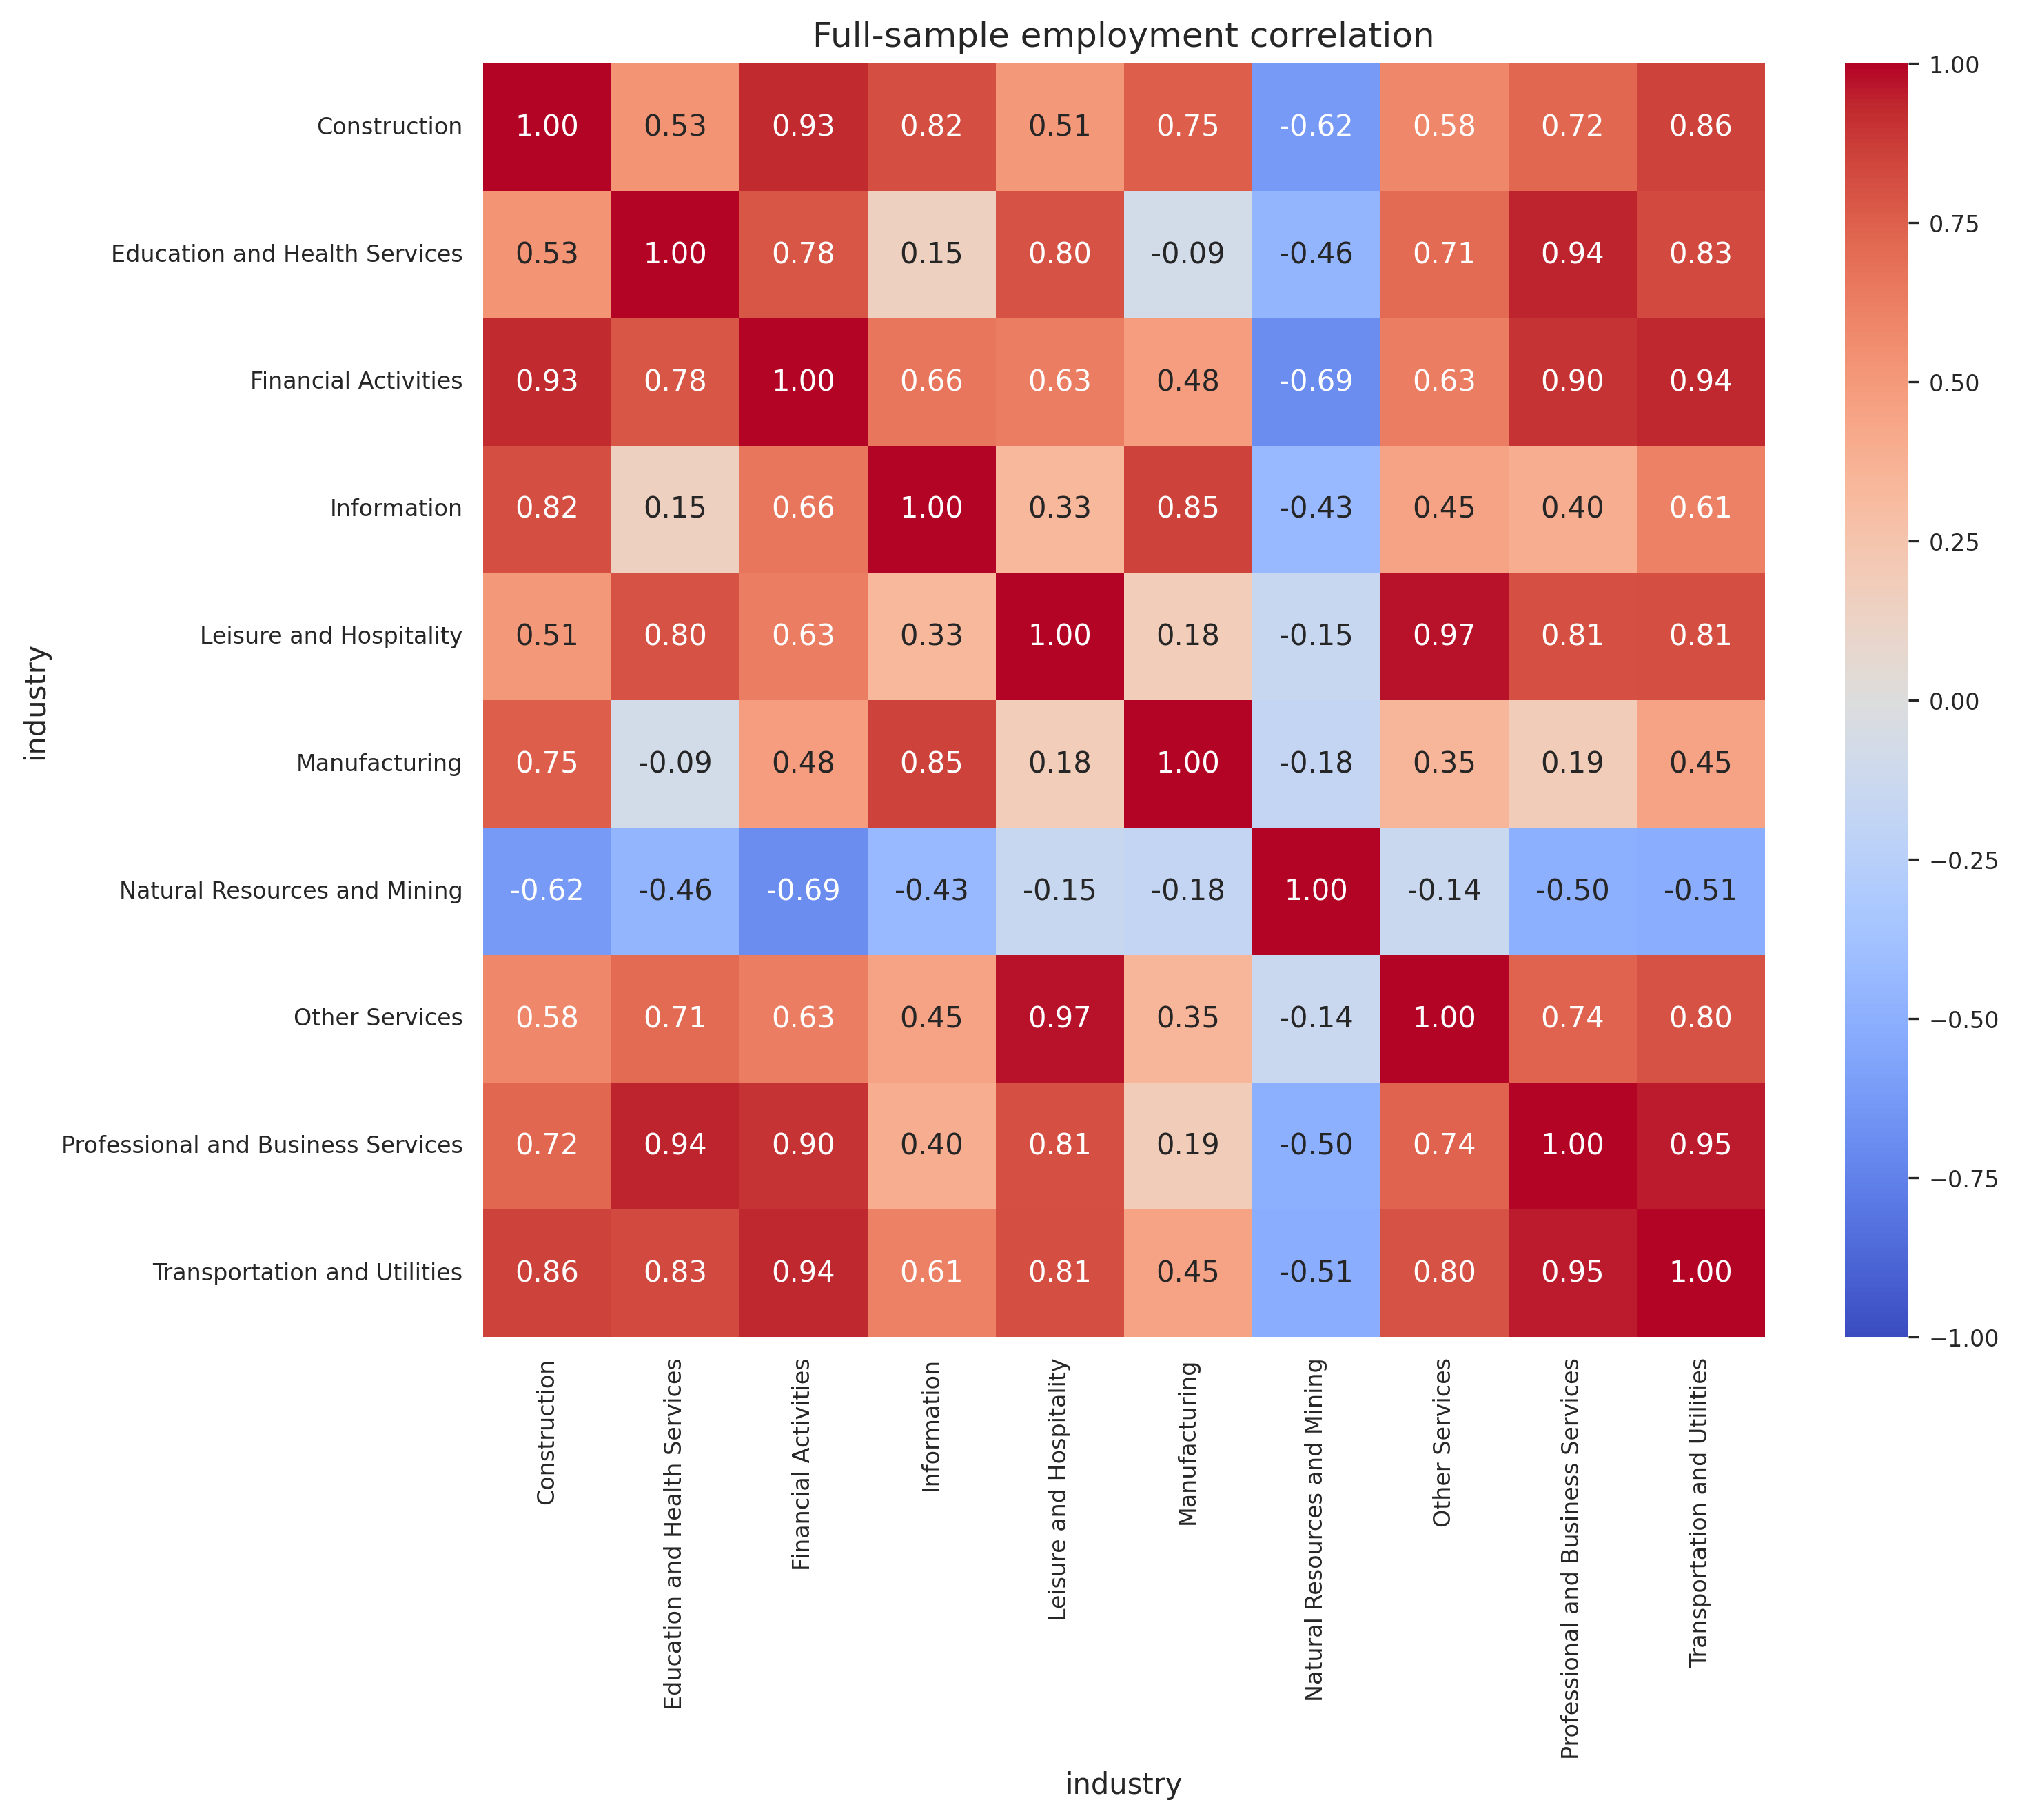

In [17]:
wide = df.pivot(index='date', columns='industry', values='y')

plt.figure(figsize=(10,8))
sns.heatmap(wide.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt='.2f')
plt.title('Full‐sample employment correlation')
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.show()

## 9. Hierarchical Clustering

/tmp/ipykernel_20387/719589399.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(1 - corr, method='average')   # distance = 1 – correlation


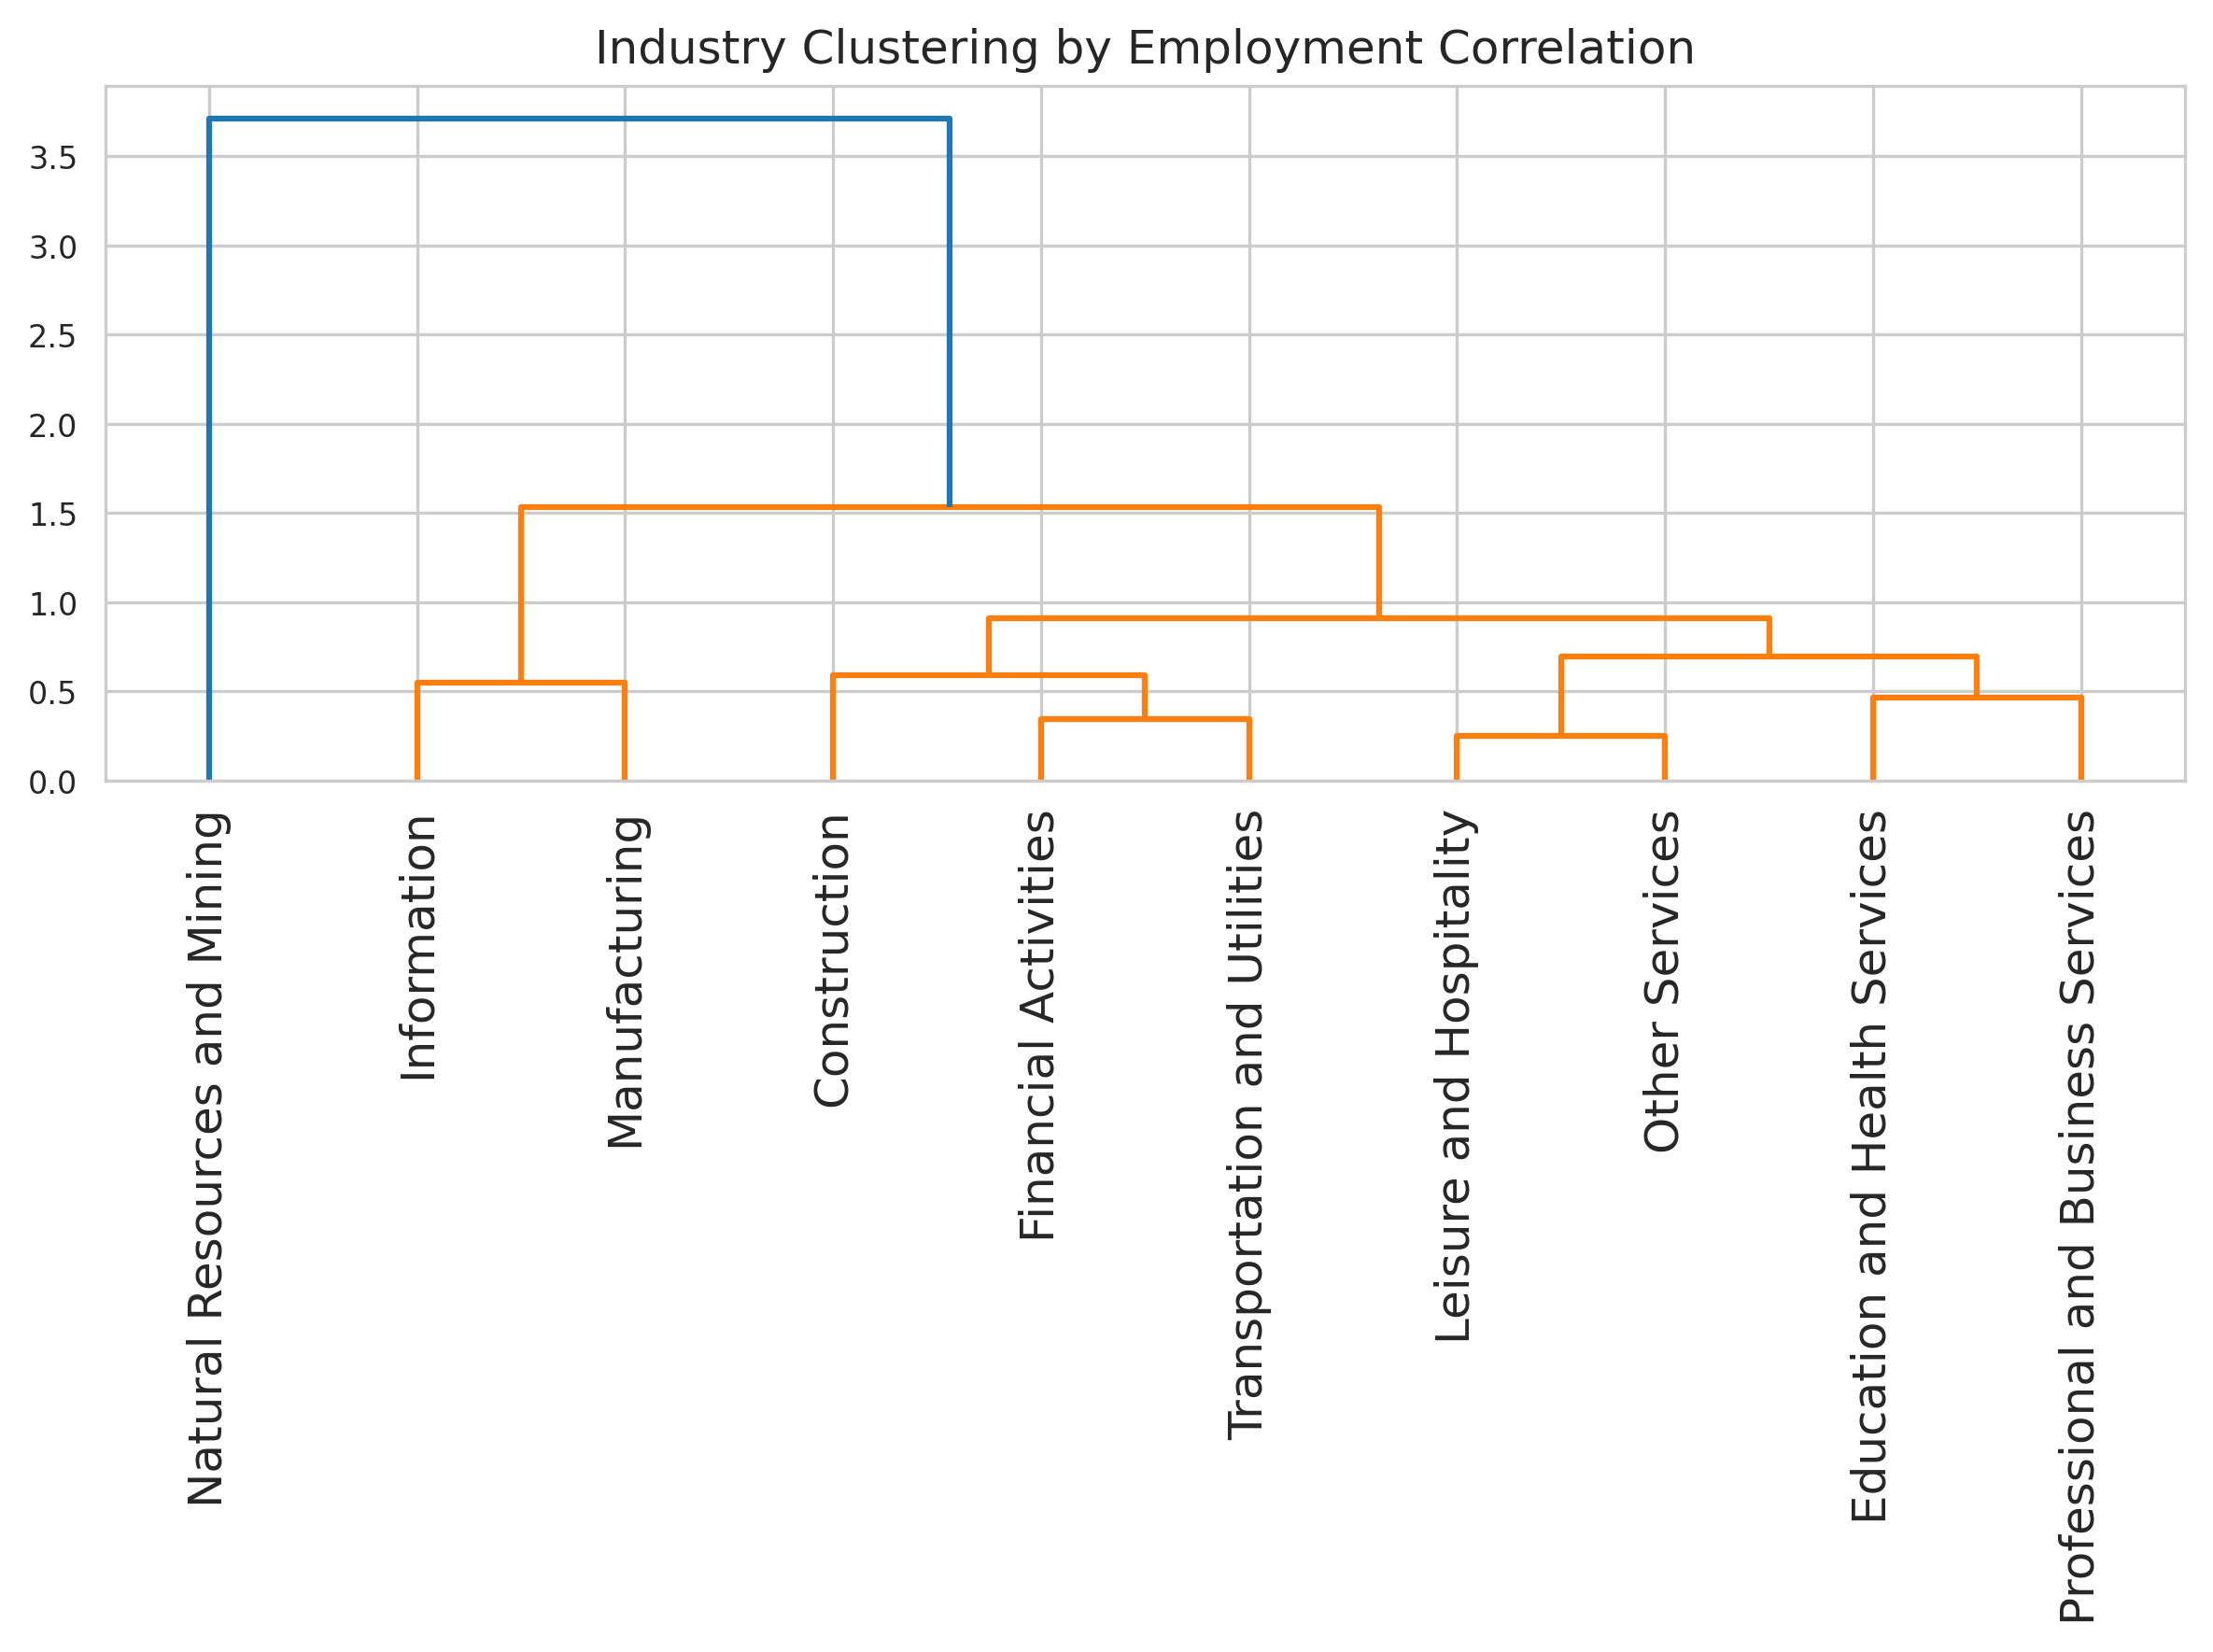

In [18]:
from scipy.cluster.hierarchy import linkage, dendrogram

# compute pairwise distances on the correlation matrix
corr = wide.corr()
link = linkage(1 - corr, method='average')   # distance = 1 – correlation

plt.figure(figsize=(8,6))
dendrogram(link, labels=corr.index, leaf_rotation=90)
plt.title('Industry Clustering by Employment Correlation')
plt.tight_layout()
plt.show()

In [11]:
from config import DATA_CONFIG, TRAINING_CONFIG
from data_processing import load_data, create_sequences, split_data

# 1) load & scale
dates, X_scaled, y_scaled, scaler_X, scaler_y, feature_names = load_data(data_file="all_industries.csv")

# 2) save scalers
import joblib
joblib.dump((scaler_X, scaler_y, feature_names), MODEL_DIR/"scaler.joblib")

# 3) build sequences on features X and target y
X_seq, y_seq = create_sequences(X_scaled, y_scaled)

# 4) split into train/val/test
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_seq, y_seq)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)



Shapes: torch.Size([1438, 12, 19]) torch.Size([360, 12, 19]) torch.Size([450, 12, 19])
